In [1]:
import os
import zipfile
import argparse
import numpy as np
# import cPickle as cp

from io import BytesIO
from pandas import Series
import pandas as pd
import pickle
from math import floor, ceil
import re


In [2]:
# Standard library imports
import inspect
import logging
import math
import os
import pickle
import random
import shutil
import subprocess
import time

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    silhouette_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import wandb
from sklearn.manifold import TSNE

# Setup Logging

In [3]:
LOG_LEVEL = "INFO" # Adjust this to "DEBUG", "INFO", "WARNING" or "ERROR"

In [4]:
# Map log level strings to logging constants
log_levels = {
    "DEBUG": logging.DEBUG,
    "INFO": logging.INFO,
    "WARNING": logging.WARNING,
    "ERROR": logging.ERROR
}
set_log_level = log_levels.get(LOG_LEVEL, logging.INFO)  


logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=set_log_level,
    datefmt="%Y-%m-%d %H:%M:%S"
)

def log_message(level, message, block=None, log_title="", caller_frame=None):
    """
    Logs a message with a specific logging level and additional details.
    
    Args:
        level (str): Logging level ('DEBUG', 'INFO', 'WARNING', 'ERROR').
        message (str): The message to log.
        block (str, optional): Additional block/section name for context.
        log_title (str): Title to specify log type.
        caller_frame (frame, optional): Frame object of the calling function.
    """
    
    line_number = caller_frame.f_lineno if caller_frame else "N/A"
    function_name = caller_frame.f_code.co_name if caller_frame else "N/A"

    
    formatted_title = log_title.ljust(7)  
    formatted_line = f"Line {line_number}".ljust(8) 


    log_msg = f"{formatted_title} | {formatted_line} | {message}"
    if block:
        log_msg += f" - Block: {block}"


    should_print = log_levels[level.upper()] >= set_log_level

    if should_print:
        print(log_msg)  

    if level.upper() == "DEBUG":
        logging.debug(log_msg)
    elif level.upper() == "INFO":
        logging.info(log_msg)
    elif level.upper() == "WARNING":
        logging.warning(log_msg)
    elif level.upper() == "ERROR":
        logging.error(log_msg)
    else:
        logging.info("Unknown log level specified.")


def print_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("INFO", message, block, log_title="INFO", caller_frame=caller_frame)

def debug_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("DEBUG", message, block, log_title="DEBUG", caller_frame=caller_frame)

def warn_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("WARNING", message, block, log_title="WARNING", caller_frame=caller_frame)

def error_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("ERROR", message, block, log_title="ERROR", caller_frame=caller_frame)

In [5]:
def clear_working_directory():
    directory_to_clear = '/kaggle/working/'

    for filename in os.listdir(directory_to_clear):
        file_path = os.path.join(directory_to_clear, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)   
        except Exception as e:
            print(f"Failed to remove {file_path}. Reason: {e}")
            
clear_working_directory()

# Hyperparamters to be changed

In [6]:
# EPOCH_BATCH_COUNT = 100
EPOCHS = 100
BATCH_SIZE = 128
CLASSES = 18
LEARNING_RATE = 0.005
SEQUENCE_LENGTH= 64
OVERLAP = 32


BEST_ACCURACY = 0.0
BEST_LOSS = 1000

MAX_SAVED_MODELS = 10

MIN_LR = 0.005
LR_FACTOR = 0.4
PATIENCE = 5


IMU_FEATURE_COUNT = 252
FEATURE_LENGTH_SINGLE_PLACEMENT = 36

# Wandb configurations

In [7]:
wandb.login(key="59bd7d0ab50dc7224820069ac4ab705f01fa85d8")
# wandb.login(key="b15ee5c84e51289dd7b5dd11ea38949957d772f9") 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
wandb.init(
    project="OPPORTUNITY - Overall",
    name = "Version-20",
#     notes = "WEIGHT_TRIPLET_LOSS=0",

    config={
        "architecture": "Transformer",
        "dataset": "Opportunity",
        "epochs": EPOCHS,
        # "epoch_batch_count" : EPOCH_BATCH_COUNT,
        "batch_size" : BATCH_SIZE,
        "imu_feature_count" : IMU_FEATURE_COUNT,
        "classes" : CLASSES,
        "learning_rate" : LEARNING_RATE,
#         "WEIGHT_CLASSIFIER_LOSS" : WEIGHT_CLASSIFIER_LOSS,
#         "WEIGHT_TRIPLET_LOSS" : WEIGHT_TRIPLET_LOSS,
        "Sequence_length":SEQUENCE_LENGTH,
        "Overlap":OVERLAP
    }
)

wandb: Currently logged in as: meenambika-20 (meenambika-20-university-of-moratuwa). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250114_133151-kpouhis8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run Version-20
wandb: ⭐️ View project at https://wandb.ai/meenambika-20-university-of-moratuwa/OPPORTUNITY%20-%20Overall
wandb: 🚀 View run at https://wandb.ai/meenambika-20-university-of-moratuwa/OPPORTUNITY%20-%20Overall/runs/kpouhis8


# Define constants

## Activities in dataset

In [9]:
activityIDdict  = {0: 'ADL0',
              1: 'ADL1',
              2: 'ADL2',
              3: 'ADL3',
              4: 'ADL4',
              5: 'ADL5',
              6: 'ADL6',
              7: 'ADL7',
              8: 'ADL8',
              9: 'ADL9',
              10: 'ADL10',
              11: 'ADL11',
              12: 'ADL12',
              13: 'ADL13',
              14: 'ADL14',
              15: 'ADL15',
              16: 'ADL16',
              17: 'ADL17'}


## Activities and suffleing

In [10]:
all_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


activity_names = [
    'ADL0',
    'ADL1',
    'ADL2',
    'ADL3',
    'ADL4',
    'ADL5',
    'ADL6',
    'ADL7',
    'ADL8',
    'ADL9',
    'ADL10',
    'ADL11',
    'ADL12',
    'ADL13',
    'ADL14',
    'ADL15',
    'ADL16',
    'ADL17'
]

# Shuffle the activity names to make them random - ##TODO: Check if we can have a seed here
# random.seed(42)
# random.shuffle(activity_names)

# Map activities to IDs dynamically
activity_id_mapping = {key: activity for key, activity in zip(all_list, activity_names)}

# Arrange all_list based on the shuffled activity names
all_list = list(activity_id_mapping.keys())

# Output the results
print("Shuffled Activity Names:", activity_names)
print("Activity ID Mapping:", activity_id_mapping)
print("Rearranged all_list:", all_list)


Shuffled Activity Names: ['ADL0', 'ADL1', 'ADL2', 'ADL3', 'ADL4', 'ADL5', 'ADL6', 'ADL7', 'ADL8', 'ADL9', 'ADL10', 'ADL11', 'ADL12', 'ADL13', 'ADL14', 'ADL15', 'ADL16', 'ADL17']
Activity ID Mapping: {0: 'ADL0', 1: 'ADL1', 2: 'ADL2', 3: 'ADL3', 4: 'ADL4', 5: 'ADL5', 6: 'ADL6', 7: 'ADL7', 8: 'ADL8', 9: 'ADL9', 10: 'ADL10', 11: 'ADL11', 12: 'ADL12', 13: 'ADL13', 14: 'ADL14', 15: 'ADL15', 16: 'ADL16', 17: 'ADL17'}
Rearranged all_list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [11]:
# Hardcoded number of sensor channels employed in the OPPORTUNITY challenge
NB_SENSOR_CHANNELS = 113
COLUMNS = []

## Define the datafiles

In [12]:
INPUT_DIR = "/kaggle/input/dataset/opportunityactivityrecognition/"

OPPORTUNITY_DATA_FILES = ['OpportunityUCIDataset/dataset/S1-Drill.dat',
                          'OpportunityUCIDataset/dataset/S1-ADL1.dat',
                          'OpportunityUCIDataset/dataset/S1-ADL2.dat',
                          'OpportunityUCIDataset/dataset/S1-ADL3.dat',
                          'OpportunityUCIDataset/dataset/S1-ADL4.dat',
                          'OpportunityUCIDataset/dataset/S1-ADL5.dat',
                          'OpportunityUCIDataset/dataset/S2-Drill.dat',
                          'OpportunityUCIDataset/dataset/S2-ADL1.dat',
                          'OpportunityUCIDataset/dataset/S2-ADL2.dat',
                          'OpportunityUCIDataset/dataset/S2-ADL3.dat',
                          'OpportunityUCIDataset/dataset/S2-ADL4.dat',
                          'OpportunityUCIDataset/dataset/S2-ADL5.dat',
                          'OpportunityUCIDataset/dataset/S3-Drill.dat',
                          'OpportunityUCIDataset/dataset/S3-ADL1.dat',
                          'OpportunityUCIDataset/dataset/S3-ADL2.dat',
                          'OpportunityUCIDataset/dataset/S3-ADL3.dat',
                          'OpportunityUCIDataset/dataset/S3-ADL4.dat',
                          'OpportunityUCIDataset/dataset/S3-ADL5.dat',
                          'OpportunityUCIDataset/dataset/S4-Drill.dat',
                          'OpportunityUCIDataset/dataset/S4-ADL1.dat',
                          'OpportunityUCIDataset/dataset/S4-ADL2.dat',
                          'OpportunityUCIDataset/dataset/S4-ADL3.dat',
                          'OpportunityUCIDataset/dataset/S4-ADL4.dat',
                          'OpportunityUCIDataset/dataset/S4-ADL5.dat',
                          ]

COLUMNS_FILE = "OpportunityUCIDataset/dataset/column_names.txt"

# Define the number of training samples
NP_TRAINING_SAMPLES = 557963

# Preprocessing

## Define Thresholds

In [13]:
# Hardcoded thresholds to define global maximums and minimums for every one of the 113 sensor channels employed in the
# OPPORTUNITY challenge
NORM_MAX_THRESHOLDS = [3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,   3000,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       3000,   3000,   3000,   10000,  10000,  10000,  1500,   1500,   1500,
                       250,    25,     200,    5000,   5000,   5000,   5000,   5000,   5000,
                       10000,  10000,  10000,  10000,  10000,  10000,  250,    250,    25,
                       200,    5000,   5000,   5000,   5000,   5000,   5000,   10000,  10000,
                       10000,  10000,  10000,  10000,  250, ]

NORM_MIN_THRESHOLDS = [-3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,  -3000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -3000,  -3000,  -3000,  -10000, -10000, -10000, -1000,  -1000,  -1000,
                       -250,   -100,   -200,   -5000,  -5000,  -5000,  -5000,  -5000,  -5000,
                       -10000, -10000, -10000, -10000, -10000, -10000, -250,   -250,   -100,
                       -200,   -5000,  -5000,  -5000,  -5000,  -5000,  -5000,  -10000, -10000,
                       -10000, -10000, -10000, -10000, -250, ]

## Filter out the columns and data

In [14]:
def select_columns_opp(data):
    """Selection of the 113 columns employed in the OPPORTUNITY challenge

    :param data: numpy integer matrix
        Sensor data (all features)
    :return: numpy integer matrix
        Selection of features
    """
    # Define the indices of columns to delete
    features_delete = np.arange(46, 50)
    features_delete = np.concatenate([features_delete, np.arange(59, 63)])
    features_delete = np.concatenate([features_delete, np.arange(72, 76)])
    features_delete = np.concatenate([features_delete, np.arange(85, 89)])
    features_delete = np.concatenate([features_delete, np.arange(98, 102)])
    features_delete = np.concatenate([features_delete, np.arange(134, 243)])
    features_delete = np.concatenate([features_delete, np.arange(244, 249)])
    # features_delete = np.concatenate([features_delete, np.arange(1, 37)])  # Accelerometer readings
    # features_delete = np.concatenate([features_delete, np.arange(47, 50)])  # IMU BACK Quaternion readings

    # Delete the specified columns from the data
    return np.delete(data, features_delete, 1), features_delete

In [15]:
def normalize(data, max_list, min_list):
    """Normalizes all sensor channels

    :param data: numpy integer matrix
        Sensor data
    :param max_list: numpy integer array
        Array containing maximums values for every one of the 113 sensor channels
    :param min_list: numpy integer array
        Array containing minimum values for every one of the 113 sensor channels
    :return:
        Normalized sensor data
    """
    max_list, min_list = np.array(max_list), np.array(min_list)
    diffs = max_list - min_list
    for i in np.arange(data.shape[1]):
        data[:, i] = (data[:, i]-min_list[i])/diffs[i]
    #     Checking the boundaries
    data[data > 1] = 0.99
    data[data < 0] = 0.00
    return data

In [16]:
def divide_x_y(data, label):
    """Segments each sample into features and label

    :param data: numpy integer matrix
        Sensor data
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized
    :return: numpy integer matrix, numpy integer array
        Features encapsulated into a matrix and labels as an array
    """

    data_x = data[:, 1:114]
    if label not in ['locomotion', 'gestures']:
            raise RuntimeError("Invalid label: '%s'" % label)
    if label == 'locomotion':
        data_y = data[:, 114]  # Locomotion label
    elif label == 'gestures':
        data_y = data[:, 115]  # Gestures label

    return data_x, data_y

In [17]:
def adjust_idx_labels(data_y, label):
    """Transforms original labels into the range [0, nb_labels-1]

    :param data_y: numpy integer array
        Sensor labels
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized
    :return: numpy integer array
        Modified sensor labels
    """

    if label == 'locomotion':  # Labels for locomotion are adjusted
        data_y[data_y == 4] = 3
        data_y[data_y == 5] = 4
    elif label == 'gestures':  # Labels for gestures are adjusted
        data_y[data_y == 406516] = 1
        data_y[data_y == 406517] = 2
        data_y[data_y == 404516] = 3
        data_y[data_y == 404517] = 4
        data_y[data_y == 406520] = 5
        data_y[data_y == 404520] = 6
        data_y[data_y == 406505] = 7
        data_y[data_y == 404505] = 8
        data_y[data_y == 406519] = 9
        data_y[data_y == 404519] = 10
        data_y[data_y == 406511] = 11
        data_y[data_y == 404511] = 12
        data_y[data_y == 406508] = 13
        data_y[data_y == 404508] = 14
        data_y[data_y == 408512] = 15
        data_y[data_y == 407521] = 16
        data_y[data_y == 405506] = 17
    return data_y

In [18]:
def check_data(data_set):
    """Try to access to the file and checks if dataset is in the data directory
       In case the file is not found try to download it from original location

    :param data_set:
            Path with original OPPORTUNITY zip file
    :return:
    """
    print ('Checking dataset {0}'.format(data_set))
    data_dir, data_file = os.path.split(data_set)
    # When a directory is not provided, check if dataset is in the data directory
    if data_dir == "" and not os.path.isfile(data_set):
        new_path = os.path.join(os.path.split(__file__)[0], "data", data_set)
        if os.path.isfile(new_path) or data_file == 'OpportunityUCIDataset.zip':
            data_set = new_path

    # When dataset not found, try to download it from UCI repository
    if (not os.path.isfile(data_set)) and data_file == 'OpportunityUCIDataset.zip':
        print ('... dataset path {0} not found'.format(data_set))
        import urllib
        origin = (
            'https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip'
        )
        if not os.path.exists(data_dir):
            print ('... creating directory {0}'.format(data_dir))
            os.makedirs(data_dir)
        print ('... downloading data from {0}'.format(origin))
        urllib.urlretrieve(origin, data_set)

    return data_dir

In [19]:
def get_index(string):
    """
    Helper function to extract the index from a line.
    get the index of the first alphabet in the string after the 9th index

    Args:
    line (str): Input line containing index information.

    Returns:
    int: Extracted index.
    """

    for i in range(9,len(string)):
        if string[i].isalpha():
            return i
    return -1

# Delete corresponding column names
def delete_column_names(columns, features_delete):
    # Use a list comprehension to keep only columns not in the features_delete indices
    return [col for idx, col in enumerate(columns) if idx not in features_delete]


def get_column_names(col_text_file, features_delete, label):
    columns = []
    # Read column names from column_names.txt file
    with open("/kaggle/input/dataset/opportunityactivityrecognition/OpportunityUCIDataset/dataset/column_names.txt", 'r') as f:
        lines = f.read().splitlines()
    
        for line in lines:
            if 'Column' in line:
                # Extract column names and append to the list
                columns.append(line[get_index(line):].split(";")[0])
    columns = delete_column_names(columns, features_delete)
    return columns[1:114]


In [20]:
def process_dataset_file(data, label):
    """Function defined as a pipeline to process individual OPPORTUNITY files

    :param data: numpy integer matrix
        Matrix containing data samples (rows) for every sensor channel (column)
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized
    :return: numpy integer matrix, numy integer array
        Processed sensor data, segmented into features (x) and labels (y)
    :return: list 
        features delete columns
    """

    # Select correct columns
    data, features_delete = select_columns_opp(data)

    # Colums are segmentd into features and labels
    data_x, data_y =  divide_x_y(data, label)
    data_y = adjust_idx_labels(data_y, label)
    data_y = data_y.astype(int)

    # Perform linear interpolation
    data_x = np.array([Series(i).interpolate() for i in data_x.T]).T

    # Remaining missing data are converted to zero
    data_x[np.isnan(data_x)] = 0

    # All sensor channels are normalized
    data_x = normalize(data_x, NORM_MAX_THRESHOLDS, NORM_MIN_THRESHOLDS)

    return data_x, data_y, features_delete

In [21]:
# def generate_data(target_dir, label):
#     """
#     Function to read the OPPORTUNITY challenge raw data and process all sensor channels,
#     then save processed datasets as CSV files, including a subject column.

#     :param target_dir: string
#         Directory where processed CSV files will be saved.
#     :param label: string, ['gestures' (default), 'locomotion']
#         Type of activities to be recognized.
#     """
#     # Initialize empty arrays for data, labels, and subjects
#     data_x = np.empty((0, NB_SENSOR_CHANNELS))
#     data_y = np.empty((0,))
#     data_subjects = []  # To store subject information
#     features_delete = []

#     print('Processing dataset files...')
#     for filename in OPPORTUNITY_DATA_FILES:
#         try:
#             # Update the file path
#             full_filename = os.path.join(INPUT_DIR, filename)
#             data = np.loadtxt(full_filename)
#             print(f"... processing file {filename} with {len(data)} rows")
            
#             # Extract the subject ID as an integer
#             subject = int(filename.split('/')[2].split('-')[0][1:])  # Remove the 'S' and convert the rest to an integer
#             print(f"The subject is {subject}")
#             adl_number =0
#             match = re.search(r"ADL(\d+)", filename)
#             if match:
#                 adl_number = int(match.group(1))
#                 print("Number after ADL:", adl_number)
#             else:
#                 print("No ADL number found.")

#             if (subject == 1 or subject ==2 or subject ==3):
#                 if (adl_number ==2 or adl_number ==3 or adl_number ==5):
#                     print("included in test")
                        
#             # Process the dataset file
#             x, y, features_delete = process_dataset_file(data, label)
#             data_x = np.vstack((data_x, x))
#             data_y = np.concatenate([data_y, y])
#             data_subjects.extend([subject] * len(x))  # Add the subject ID for each row
#         except Exception as e:
#             print(f"ERROR: Could not process {filename}: {e}")

#     # Define the number of training samples
#     #nb_training_samples = 557963

#     # Split into training and testing datasets
#     #X_train, y_train = data_x[:nb_training_samples, :], data_y[:nb_training_samples]
#     #subjects_train = data_subjects[:nb_training_samples]
#     #X_test, y_test = data_x[nb_training_samples:, :], data_y[nb_training_samples:]
#     #subjects_test = data_subjects[nb_training_samples:]

#     data = data_x, data_y, data_subjects
    

#     col_file_path = os.path.join(INPUT_DIR, COLUMNS_FILE)
#     columns = get_column_names(col_file_path, features_delete, label)
#     print(f"The length of columns = {len(columns)}")
    
#     print("Saving datasets as CSV files...")

#     # Ensure target directory exists
#     os.makedirs(target_dir, exist_ok=True)

#     # Save training data
#     #train_df = pd.DataFrame(X_train, columns=columns)
#     #train_df['label'] = y_train
#     #train_df['subject'] = subjects_train  # Add subject column
#     #train_file = os.path.join(target_dir, 'train_data.csv')
#     #train_df.to_csv(train_file, index=False)
#     #print(f"Training data saved to {train_file}")

#     # Save testing data
#     #test_df = pd.DataFrame(X_test, columns=columns)
#     #test_df['label'] = y_test
#     #test_df['subject'] = subjects_test  # Add subject column
#     #test_file = os.path.join(target_dir, 'test_data.csv')
#     #test_df.to_csv(test_file, index=False)
#     #print(f"Testing data saved to {test_file}")

#     # Save  data
#     data_df = pd.DataFrame(data_x, columns=columns)
#     data_df['label'] = data_y
#     data_df['subject'] = data_subjects  # Add subject column
#     print(f"Final data capture data shape : {data_df.shape}")
#    # data_file = os.path.join(target_dir, 'data.csv')
#    # data_df.to_csv(data_file, index=False)
#    # print(f"Data saved to {data_file}")
    
#     #print("Final datasets saved as CSV files")
#     return data_df


In [22]:
# TEST_TEST_DF = generate_data("/kaggle/working/data", label='gestures')

## With train_test_split

In [23]:
def generate_data(target_dir, label):
    """
    Function to read the OPPORTUNITY challenge raw data and process all sensor channels,
    then save processed datasets as CSV files, including a subject column.

    :param target_dir: string
        Directory where processed CSV files will be saved.
    :param label: string, ['gestures' (default), 'locomotion']
        Type of activities to be recognized.
    """
    # Initialize empty arrays for data, labels, and subjects
    train_data_x = np.empty((0, NB_SENSOR_CHANNELS))
    train_data_y = np.empty((0,))
    train_data_subjects = []
    test_data_x = np.empty((0, NB_SENSOR_CHANNELS))
    test_data_y = np.empty((0,))
    test_data_subjects = []  # To store subject information
    features_delete = []

    print('Processing dataset files...')
    for filename in OPPORTUNITY_DATA_FILES:
        try:
            # Update the file path
            full_filename = os.path.join(INPUT_DIR, filename)
            data = np.loadtxt(full_filename)
            print(f"... processing file {filename} with {len(data)} rows")
            
            # Extract the subject ID as an integer
            subject = int(filename.split('/')[2].split('-')[0][1:])  # Remove the 'S' and convert the rest to an integer
            print(f"The subject is {subject}")
            adl_number =0
            match = re.search(r"ADL(\d+)", filename)
            if match:
                adl_number = int(match.group(1))
                print("Number after ADL:", adl_number)
            else:
                print("No ADL number found.")

            # if (subject == 1 or subject ==2 or subject ==3):
            #     if (adl_number ==2 or adl_number ==3 or adl_number ==5):
            #         print("included in test")
            #         x, y, features_delete = process_dataset_file(data, label)
            #         test_data_x = np.vstack((test_data_x, x))
            #         test_data_y = np.concatenate([test_data_x, y])
            #         test_data_subjects.extend([subject] * len(x))  # Add the subject ID for each row
            #     else:
                    
            #         print("included in train")
            #         x, y, features_delete = process_dataset_file(data, label)
            #         train_data_x = np.vstack((train_data_x, x))
            #         train_data_y = np.concatenate([train_data_y, y])
            #         train_data_subjects.extend([subject] * len(x)) 
            # else:
            #     print("included in train")
            #     x, y, features_delete = process_dataset_file(data, label)
            #     train_data_x = np.vstack((train_data_x, x))
            #     train_data_y = np.concatenate([train_data_y, y])
            #     train_data_subjects.extend([subject] * len(x)) 
                    
            if (subject == 1 or subject == 2 or subject == 3) and (adl_number == 2 or adl_number == 3 or adl_number == 5):
                print("included in test")
                x, y, features_delete = process_dataset_file(data, label)
                test_data_x = np.vstack((test_data_x, x))
                test_data_y = np.concatenate([test_data_y, y])
                test_data_subjects.extend([subject] * len(x))  # Add the subject ID for each row
            else:
                print(subject,"subject", adl_number,"adl_number")
                print("included in train")
                x, y, features_delete = process_dataset_file(data, label)
                train_data_x = np.vstack((train_data_x, x))
                train_data_y = np.concatenate([train_data_y, y])
                train_data_subjects.extend([subject] * len(x))
            # Process the dataset file
            
        except Exception as e:
            print(f"ERROR: Could not process {filename}: {e}")

    # Define the number of training samples
    #nb_training_samples = 557963

    # Split into training and testing datasets
    #X_train, y_train = data_x[:nb_training_samples, :], data_y[:nb_training_samples]
    #subjects_train = data_subjects[:nb_training_samples]
    #X_test, y_test = data_x[nb_training_samples:, :], data_y[nb_training_samples:]
    #subjects_test = data_subjects[nb_training_samples:]

    train_data = train_data_x, train_data_y, train_data_subjects
    test_data = test_data_x, test_data_y, test_data_subjects
    

    col_file_path = os.path.join(INPUT_DIR, COLUMNS_FILE)
    columns = get_column_names(col_file_path, features_delete, label)
    print(f"The length of columns = {len(columns)}")
    
    print("Saving datasets as CSV files...")

    # Ensure target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Save training data
    #train_df = pd.DataFrame(X_train, columns=columns)
    #train_df['label'] = y_train
    #train_df['subject'] = subjects_train  # Add subject column
    #train_file = os.path.join(target_dir, 'train_data.csv')
    #train_df.to_csv(train_file, index=False)
    #print(f"Training data saved to {train_file}")

    # Save testing data
    #test_df = pd.DataFrame(X_test, columns=columns)
    #test_df['label'] = y_test
    #test_df['subject'] = subjects_test  # Add subject column
    #test_file = os.path.join(target_dir, 'test_data.csv')
    #test_df.to_csv(test_file, index=False)
    #print(f"Testing data saved to {test_file}")

    # Save  data
    train_data_df = pd.DataFrame(train_data_x, columns=columns)
    train_data_df['label'] = train_data_y
    train_data_df['subject'] = train_data_subjects  # Add subject column
    print(f"Final data capture data shape : {train_data_df.shape}")

    test_data_df = pd.DataFrame(test_data_x, columns=columns)
    test_data_df['label'] = test_data_y
    test_data_df['subject'] = test_data_subjects  # Add subject column
    print(f"Final data capture data shape : {test_data_df.shape}")
   # data_file = os.path.join(target_dir, 'data.csv')
   # data_df.to_csv(data_file, index=False)
   # print(f"Data saved to {data_file}")
    
    #print("Final datasets saved as CSV files")
    return train_data_df,test_data_df


In [24]:
# generate_data(target_filename='oppChallenge_gestures.csv', label='gestures')

In [25]:
TRAIN_DATA_DF,TEST_DATA_DF = generate_data("/kaggle/working/data", label='gestures')

Processing dataset files...
... processing file OpportunityUCIDataset/dataset/S1-Drill.dat with 54966 rows
The subject is 1
No ADL number found.
1 subject 0 adl_number
included in train
... processing file OpportunityUCIDataset/dataset/S1-ADL1.dat with 51116 rows
The subject is 1
Number after ADL: 1
1 subject 1 adl_number
included in train
... processing file OpportunityUCIDataset/dataset/S1-ADL2.dat with 32224 rows
The subject is 1
Number after ADL: 2
included in test
... processing file OpportunityUCIDataset/dataset/S1-ADL3.dat with 33273 rows
The subject is 1
Number after ADL: 3
included in test
... processing file OpportunityUCIDataset/dataset/S1-ADL4.dat with 32955 rows
The subject is 1
Number after ADL: 4
1 subject 4 adl_number
included in train
... processing file OpportunityUCIDataset/dataset/S1-ADL5.dat with 30127 rows
The subject is 1
Number after ADL: 5
included in test
... processing file OpportunityUCIDataset/dataset/S2-Drill.dat with 53398 rows
The subject is 2
No ADL num

## Delete Unwanted columns (113 => 77)

In [26]:
train_data_df = TRAIN_DATA_DF.copy()
test_data_df =TEST_DATA_DF.copy()

In [27]:
# Drop the Accelerotion of each device
train_data_df = train_data_df.drop(TRAIN_DATA_DF.columns[:36], axis=1)
test_data_df = test_data_df.drop(TEST_DATA_DF.columns[:36], axis=1)
# Drop the left and right shoe sensor readings
#data_df = data_df.drop(data_df.columns[45:-2], axis=1)

In [28]:
train_data_df.head()

,InertialMeasurementUnit BACK accX,InertialMeasurementUnit BACK accY,InertialMeasurementUnit BACK accZ,InertialMeasurementUnit BACK gyroX,InertialMeasurementUnit BACK gyroY,InertialMeasurementUnit BACK gyroZ,InertialMeasurementUnit BACK magneticX,InertialMeasurementUnit BACK magneticY,InertialMeasurementUnit BACK magneticZ,InertialMeasurementUnit RUA accX,...,InertialMeasurementUnit R-SHOE Body_Az,InertialMeasurementUnit R-SHOE AngVelBodyFrameX,InertialMeasurementUnit R-SHOE AngVelBodyFrameY,InertialMeasurementUnit R-SHOE AngVelBodyFrameZ,InertialMeasurementUnit R-SHOE AngVelNavFrameX,InertialMeasurementUnit R-SHOE AngVelNavFrameY,InertialMeasurementUnit R-SHOE AngVelNavFrameZ,InertialMeasurementUnit R-SHOE Compass,label,subject
0,0.341667,0.462500,0.494500,0.43300,0.48560,0.49280,0.6348,0.2276,0.2968,0.335833,...,0.4183,0.50190,0.50170,0.50105,0.50170,0.49810,0.50105,0.836,0.0,1
1,0.344500,0.456667,0.495167,0.42700,0.48445,0.49430,0.6332,0.2340,0.2868,0.341500,...,0.4179,0.50345,0.50400,0.50060,0.50400,0.49655,0.50060,0.836,0.0,1
2,0.346000,0.453500,0.496667,0.42795,0.48220,0.49330,0.6316,0.2412,0.2760,0.344667,...,0.4179,0.50250,0.50275,0.50050,0.50275,0.49750,0.50050,0.836,0.0,1
3,0.344667,0.451333,0.496667,0.43095,0.48130,0.49545,0.6300,0.2476,0.2656,0.343333,...,0.4186,0.50135,0.50090,0.50045,0.50090,0.49865,0.50045,0.836,0.0,1
4,0.343667,0.450167,0.491667,0.43700,0.48140,0.49685,0.6280,0.2544,0.2556,0.338333,...,0.4190,0.50060,0.50250,0.49925,0.50250,0.49940,0.49925,0.836,0.0,1


In [29]:
train_data_df = train_data_df.drop(train_data_df.columns[-3], axis=1)
train_data_df = train_data_df.drop(train_data_df.columns[-19], axis=1)
train_data_df = train_data_df.drop(train_data_df.columns[-28:-22], axis=1)
train_data_df = train_data_df.drop(train_data_df.columns[-12:-6], axis=1)

test_data_df = test_data_df.drop(test_data_df.columns[-3], axis=1)
test_data_df = test_data_df.drop(test_data_df.columns[-19], axis=1)
test_data_df = test_data_df.drop(test_data_df.columns[-28:-22], axis=1)
test_data_df = test_data_df.drop(test_data_df.columns[-12:-6], axis=1)

In [30]:
columns = train_data_df.columns
columns

Index(['InertialMeasurementUnit BACK accX',
       'InertialMeasurementUnit BACK accY',
       'InertialMeasurementUnit BACK accZ',
       'InertialMeasurementUnit BACK gyroX',
       'InertialMeasurementUnit BACK gyroY',
       'InertialMeasurementUnit BACK gyroZ',
       'InertialMeasurementUnit BACK magneticX',
       'InertialMeasurementUnit BACK magneticY',
       'InertialMeasurementUnit BACK magneticZ',
       'InertialMeasurementUnit RUA accX', 'InertialMeasurementUnit RUA accY',
       'InertialMeasurementUnit RUA accZ', 'InertialMeasurementUnit RUA gyroX',
       'InertialMeasurementUnit RUA gyroY',
       'InertialMeasurementUnit RUA gyroZ',
       'InertialMeasurementUnit RUA magneticX',
       'InertialMeasurementUnit RUA magneticY',
       'InertialMeasurementUnit RUA magneticZ',
       'InertialMeasurementUnit RLA accX', 'InertialMeasurementUnit RLA accY',
       'InertialMeasurementUnit RLA accZ', 'InertialMeasurementUnit RLA gyroX',
       'InertialMeasurementUnit RLA 

In [31]:
#columns[-3]
columns[-19]
columns[-28:-22]
columns[-12:-6]

Index(['InertialMeasurementUnit L-SHOE Compass',
       'InertialMeasurementUnit R-SHOE EuX',
       'InertialMeasurementUnit R-SHOE EuY',
       'InertialMeasurementUnit R-SHOE EuZ',
       'InertialMeasurementUnit R-SHOE Nav_Ax',
       'InertialMeasurementUnit R-SHOE Nav_Ay'],
      dtype='object')

In [32]:
len(columns)

65

In [33]:
COLUMNS = ['back_acc_1','back_acc_2','back_acc_3','back_gyro_1','back_gyro_2','back_gyro_3','back_mag_1','back_mag_2','back_mag_3',
           'rua_acc_1','rua_acc_2','rua_acc_3','rua_gyro_1','rua_gyro_2','rua_gyro_3','rua_mag_1','rua_mag_2','rua_mag_3',
           'rla_acc_1','rla_acc_2','rla_acc_3','rla_gyro_1','rla_gyro_2','rla_gyro_3','rla_mag_1','rla_mag_2','rla_mag_3',
           'lua_acc_1','lua_acc_2','lua_acc_3','lua_gyro_1','lua_gyro_2','lua_gyro_3','lua_mag_1','lua_mag_2','lua_mag_3',
           'lla_acc_1','lla_acc_2','lla_acc_3', 'lla_gyro_1','lla_gyro_2','lla_gyro_3', 'lla_mag_1','lla_mag_2','lla_mag_3',
           'ls_Eu_1','ls_Eu_2','ls_Eu_3', 'ls_Nav_A_1','ls_Nav_A_2','ls_Nav_A_3','ls_AngVelNavFrame_1','ls_AngVelNavFrame_2','ls_AngVelNavFrame_3',
           'rs_Eu_1','rs_Eu_2','rs_Eu_3', 'rs_Nav_A_1','rs_Nav_A_2','rs_Nav_A_3','rs_AngVelNavFrame_1','rs_AngVelNavFrame_2','rs_AngVelNavFrame_3',
           'activity_id', 'subject_id'
          ]

# Rename columns in both train_df and test_df
train_data_df.columns = COLUMNS
test_data_df.columns = COLUMNS


In [34]:
train_data_df.columns

Index(['back_acc_1', 'back_acc_2', 'back_acc_3', 'back_gyro_1', 'back_gyro_2',
       'back_gyro_3', 'back_mag_1', 'back_mag_2', 'back_mag_3', 'rua_acc_1',
       'rua_acc_2', 'rua_acc_3', 'rua_gyro_1', 'rua_gyro_2', 'rua_gyro_3',
       'rua_mag_1', 'rua_mag_2', 'rua_mag_3', 'rla_acc_1', 'rla_acc_2',
       'rla_acc_3', 'rla_gyro_1', 'rla_gyro_2', 'rla_gyro_3', 'rla_mag_1',
       'rla_mag_2', 'rla_mag_3', 'lua_acc_1', 'lua_acc_2', 'lua_acc_3',
       'lua_gyro_1', 'lua_gyro_2', 'lua_gyro_3', 'lua_mag_1', 'lua_mag_2',
       'lua_mag_3', 'lla_acc_1', 'lla_acc_2', 'lla_acc_3', 'lla_gyro_1',
       'lla_gyro_2', 'lla_gyro_3', 'lla_mag_1', 'lla_mag_2', 'lla_mag_3',
       'ls_Eu_1', 'ls_Eu_2', 'ls_Eu_3', 'ls_Nav_A_1', 'ls_Nav_A_2',
       'ls_Nav_A_3', 'ls_AngVelNavFrame_1', 'ls_AngVelNavFrame_2',
       'ls_AngVelNavFrame_3', 'rs_Eu_1', 'rs_Eu_2', 'rs_Eu_3', 'rs_Nav_A_1',
       'rs_Nav_A_2', 'rs_Nav_A_3', 'rs_AngVelNavFrame_1',
       'rs_AngVelNavFrame_2', 'rs_AngVelNavFrame_3', 'acti

In [35]:
len(test_data_df.columns)

65

In [36]:
test_data_df.isnull().sum()

back_acc_1             0
back_acc_2             0
back_acc_3             0
back_gyro_1            0
back_gyro_2            0
                      ..
rs_AngVelNavFrame_1    0
rs_AngVelNavFrame_2    0
rs_AngVelNavFrame_3    0
activity_id            0
subject_id             0
Length: 65, dtype: int64

In [37]:
train_data_df.describe()

,back_acc_1,back_acc_2,back_acc_3,back_gyro_1,back_gyro_2,back_gyro_3,back_mag_1,back_mag_2,back_mag_3,rua_acc_1,...,rs_Eu_2,rs_Eu_3,rs_Nav_A_1,rs_Nav_A_2,rs_Nav_A_3,rs_AngVelNavFrame_1,rs_AngVelNavFrame_2,rs_AngVelNavFrame_3,activity_id,subject_id
count,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,...,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000,596486.000000
mean,0.359060,0.473696,0.547895,0.497735,0.499401,0.500212,0.583560,0.400618,0.391104,0.358691,...,0.522635,0.413706,0.499013,0.500542,0.500012,0.500721,0.499686,0.500012,3.149677,2.640657
std,0.042676,0.036672,0.049382,0.030218,0.017731,0.012600,0.133774,0.140754,0.192565,0.042252,...,0.124782,0.212429,0.041212,0.041928,0.051371,0.044765,0.075932,0.051371,5.514987,1.158635
min,0.178500,0.262833,0.269000,0.259100,0.256400,0.385350,0.028400,0.000000,0.000000,0.183000,...,0.056000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.336833,0.454833,0.516000,0.486200,0.493750,0.495450,0.537200,0.293200,0.202400,0.336167,...,0.464000,0.137500,0.497200,0.498300,0.498200,0.497700,0.497850,0.498200,0.000000,2.000000
50%,0.345000,0.474000,0.540500,0.499050,0.499600,0.499900,0.596400,0.395200,0.402000,0.347667,...,0.528000,0.512500,0.500000,0.500000,0.500000,0.500050,0.500000,0.500000,0.000000,3.000000
75%,0.364500,0.491667,0.572833,0.508400,0.504950,0.504700,0.645200,0.498000,0.556800,0.374667,...,0.600000,0.550000,0.501700,0.502800,0.502300,0.502550,0.502150,0.502300,4.000000,4.000000
max,0.709000,0.802500,0.767000,0.686850,0.671150,0.611550,1.000000,0.831200,0.979600,0.811333,...,1.000000,1.000000,1.000000,0.999300,0.992950,0.997350,0.998650,0.992950,17.000000,4.000000


## Plots of data

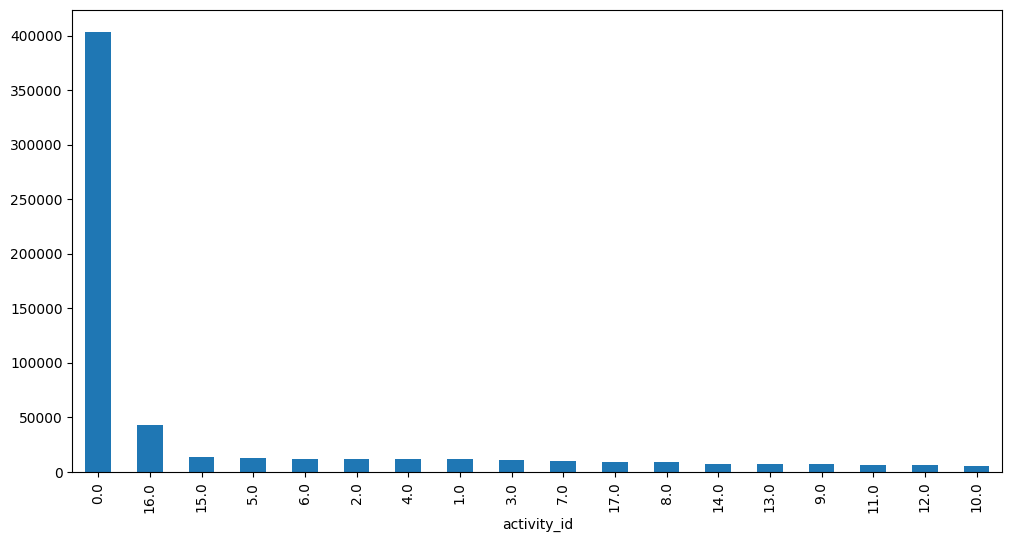

In [38]:
train_data_df['activity_id'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.show()

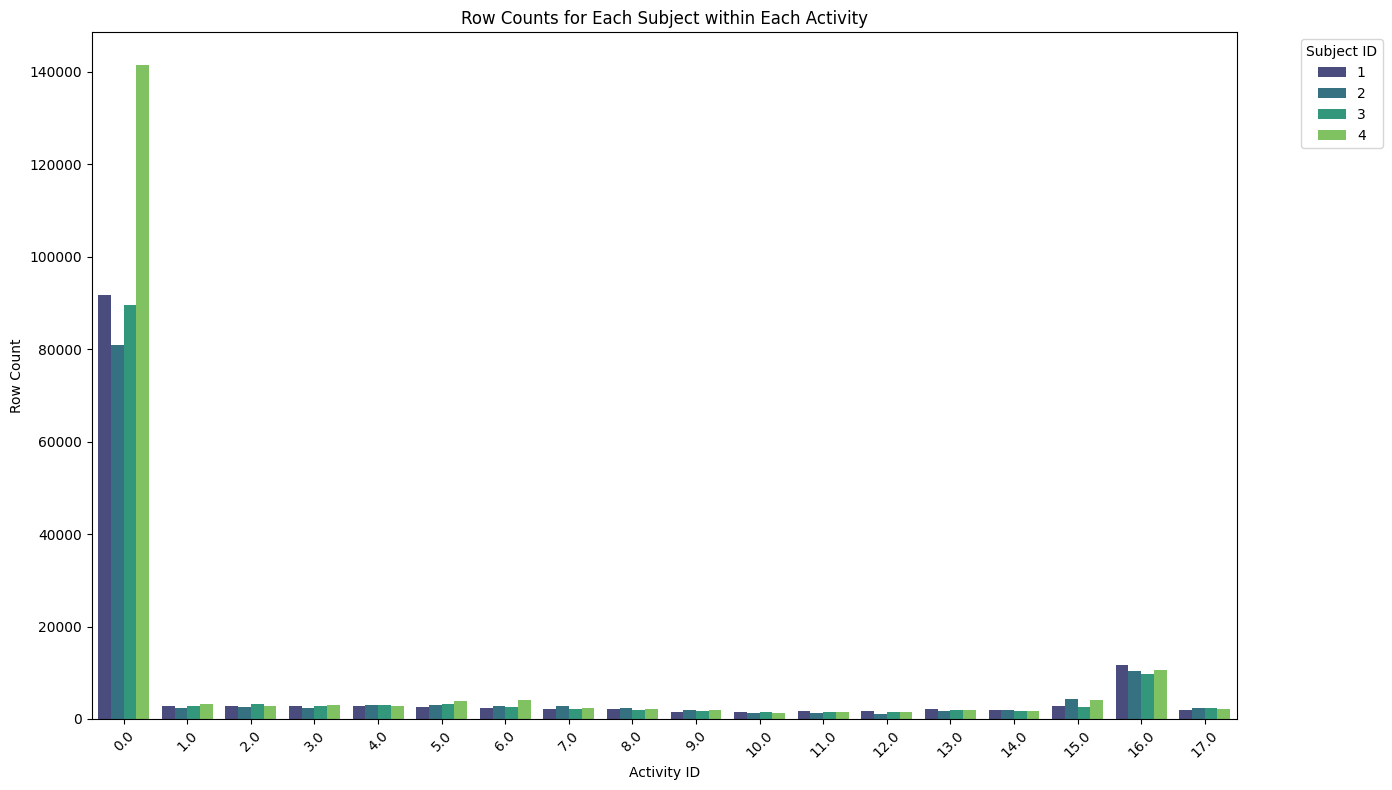

In [39]:
# Group by 'activityID' and 'subject_id' to count rows for each combination
activity_subject_counts = train_data_df.groupby(['activity_id', 'subject_id']).size().reset_index(name='Count')

# Set plot size for better readability
plt.figure(figsize=(14, 8))

# Create a bar plot with 'activityID' on the x-axis and 'Count' on the y-axis, colored by 'subject_id'
sns.barplot(data=activity_subject_counts, x='activity_id', y='Count', hue='subject_id', dodge=True, palette='viridis')

# Customize plot appearance
plt.title('Row Counts for Each Subject within Each Activity')
plt.xlabel('Activity ID')
plt.ylabel('Row Count')
plt.legend(title='Subject ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

## Create csv files

In [40]:
unique_activity_ids_temp = train_data_df['activity_id'].unique()
unique_activity_ids = unique_activity_ids_temp.astype(int)

unique_activity_ids


array([ 0,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  3,  1,  4,  2, 17, 15,
       16])

In [41]:
unique_subject_ids = train_data_df['subject_id'].unique()
unique_subject_ids

array([1, 2, 3, 4])

In [42]:
base_dir = './activity_data'
activity_counts = []

train_dir = os.path.join('./', 'train')
test_dir = os.path.join('./', 'test')
validation_dir = os.path.join('./', 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

 
import os
import pandas as pd

def save_activity_data(data_df, unique_activity_ids, unique_subject_ids, base_dir, category='train'):
    """
    Processes activity data and saves it to train, test, or validation folders.

    Args:
        data_df (pd.DataFrame): Input DataFrame containing activity and subject data.
        unique_activity_ids (list): List of unique activity IDs.
        unique_subject_ids (list): List of unique subject IDs.
        base_dir (str): Base directory to save the data.
        category (str): Category name ('train', 'test', or 'validation').

    Returns:
        activity_counts (list): List of tuples containing (activity_id, subject_id, row_count).
    """
    # Initialize counters and directories
    activity_counts = []
    category_dir = os.path.join(base_dir, category)
    os.makedirs(category_dir, exist_ok=True)

    for activity_id in unique_activity_ids:
        activity_dir = os.path.join(category_dir, f'{activity_id}')
        os.makedirs(activity_dir, exist_ok=True)

        saved_csv_files = []

        for subject_id in unique_subject_ids:
            # Filter DataFrame for the specific activity and subject
            df_activity_subject = data_df[
                (data_df['activity_id'] == activity_id) & 
                (data_df['subject_id'] == subject_id)
            ]

            row_count = len(df_activity_subject)

            if row_count <= 1:
                print(f'Skipped {subject_id} for activity {activity_id} due to insufficient data ({row_count} rows)')
                continue

            # Save the filtered data to a CSV file
            filename = os.path.join(activity_dir, f'{subject_id}.csv')
            df_activity_subject.to_csv(filename, index=False)

            # Update counters and log saved files
            activity_counts.append((activity_id, subject_id, row_count))
            saved_csv_files.append(filename)
            print(f'Saved {filename}')

        # Log existing files in the directory
        existing_csv_files = os.listdir(activity_dir)
        current_csv_count = len(existing_csv_files)
        print(f'Existing CSV files in {activity_dir}: {existing_csv_files}')
        print(f'Current CSV count: {current_csv_count}')

    return activity_counts

save_activity_data(train_data_df, unique_activity_ids, unique_subject_ids, base_dir, category='train')
save_activity_data(test_data_df, unique_activity_ids, unique_subject_ids, base_dir, category='test')

Saved ./activity_data/train/0/1.csv
Saved ./activity_data/train/0/2.csv
Saved ./activity_data/train/0/3.csv
Saved ./activity_data/train/0/4.csv
Existing CSV files in ./activity_data/train/0: ['2.csv', '3.csv', '4.csv', '1.csv']
Current CSV count: 4
Saved ./activity_data/train/5/1.csv
Saved ./activity_data/train/5/2.csv
Saved ./activity_data/train/5/3.csv
Saved ./activity_data/train/5/4.csv
Existing CSV files in ./activity_data/train/5: ['2.csv', '3.csv', '4.csv', '1.csv']
Current CSV count: 4
Saved ./activity_data/train/6/1.csv
Saved ./activity_data/train/6/2.csv
Saved ./activity_data/train/6/3.csv
Saved ./activity_data/train/6/4.csv
Existing CSV files in ./activity_data/train/6: ['2.csv', '3.csv', '4.csv', '1.csv']
Current CSV count: 4
Saved ./activity_data/train/7/1.csv
Saved ./activity_data/train/7/2.csv
Saved ./activity_data/train/7/3.csv
Saved ./activity_data/train/7/4.csv
Existing CSV files in ./activity_data/train/7: ['2.csv', '3.csv', '4.csv', '1.csv']
Current CSV count: 4
Save

[(0, 1, 78210),
 (0, 2, 81163),
 (0, 3, 65422),
 (5, 1, 1079),
 (5, 2, 1888),
 (5, 3, 2151),
 (6, 1, 1190),
 (6, 2, 1424),
 (6, 3, 1519),
 (7, 1, 390),
 (7, 2, 999),
 (7, 3, 662),
 (8, 1, 499),
 (8, 2, 780),
 (8, 3, 715),
 (9, 1, 483),
 (9, 2, 439),
 (9, 3, 318),
 (10, 1, 574),
 (10, 2, 335),
 (10, 3, 421),
 (11, 1, 480),
 (11, 2, 397),
 (11, 3, 410),
 (12, 1, 395),
 (12, 2, 337),
 (12, 3, 219),
 (13, 1, 871),
 (13, 2, 553),
 (13, 3, 568),
 (14, 1, 647),
 (14, 2, 512),
 (14, 3, 625),
 (3, 1, 1096),
 (3, 2, 732),
 (3, 3, 570),
 (1, 1, 1408),
 (1, 2, 720),
 (1, 3, 803),
 (4, 1, 1080),
 (4, 2, 673),
 (4, 3, 589),
 (2, 1, 1329),
 (2, 2, 690),
 (2, 3, 899),
 (17, 1, 700),
 (17, 2, 829),
 (17, 3, 719),
 (15, 1, 352),
 (15, 2, 1356),
 (15, 3, 622),
 (16, 1, 4841),
 (16, 2, 2413),
 (16, 3, 3805)]

## IMU Feature extraction

In [43]:
def imu_feature_extract(imu_type_data):
    if imu_type_data.shape[0] < 3:  # Minimum required rows for np.gradient with edge_order=2
        print("Not enough rows to calculate gradient. Skipping this file.")
        return pd.DataFrame()
    imu_type_data["fft_x"] = np.abs(np.fft.fft(imu_type_data["x"].values))
    imu_type_data["fft_y"] = np.abs(np.fft.fft(imu_type_data["y"].values))
    imu_type_data["fft_z"] = np.abs(np.fft.fft(imu_type_data["z"].values))

    imu_type_data["fd_x"] = np.gradient(imu_type_data["x"].values, edge_order=2)
    imu_type_data["fd_y"] = np.gradient(imu_type_data["y"].values, edge_order=2)
    imu_type_data["fd_z"] = np.gradient(imu_type_data["z"].values, edge_order=2)

    imu_type_data["sd_x"] = np.gradient(imu_type_data["fd_x"].values, edge_order=2)
    imu_type_data["sd_y"] = np.gradient(imu_type_data["fd_y"].values, edge_order=2)
    imu_type_data["sd_z"] = np.gradient(imu_type_data["fd_z"].values, edge_order=2)

    return imu_type_data

In [44]:
# When both hand and chest placements are considered - We need to add a logic here for every placement
imu_prefixes = ['back_acc','back_gyro','back_mag', 'rua_acc','rua_gyro','rua_mag', 'rla_acc','rla_gyro','rla_mag', 'lua_acc','lua_gyro','lua_mag', 'lla_acc','lla_gyro','lla_mag','ls_Eu','ls_Nav_A','ls_AngVelNavFrame','rs_Eu','rs_Nav_A','rs_AngVelNavFrame']

In [45]:
def apply_imu_feature_extraction(dataCol, imu_cols):
    new_columns = []  

    for col_prefix in imu_cols:

        imu_data = dataCol[[f"{col_prefix}_1", f"{col_prefix}_2", f"{col_prefix}_3"]].copy()
        imu_data.columns = ['x', 'y', 'z']
        
        extracted_features = imu_feature_extract(imu_data)
        
        new_cols = pd.DataFrame()
        for feature in extracted_features.columns:
            new_cols[f"{col_prefix}_{feature}"] = extracted_features[feature]

        new_columns.append(new_cols)

    dataCol = pd.concat([dataCol] + new_columns, axis=1)

    for col_prefix in imu_cols:
        dataCol.drop(columns=[f"{col_prefix}_1", f"{col_prefix}_2", f"{col_prefix}_3"], inplace=True)
    
    return dataCol


In [46]:
def scaling(dataframe):
    std_scaler = StandardScaler()
    columns_names = list(dataframe.columns)
    dataframe = std_scaler.fit_transform(dataframe.to_numpy())
    dataframe = pd.DataFrame(dataframe, columns=columns_names)
    return dataframe

## Generate Sequence

In [47]:
train_sequences=[]
validation_sequences=[]
test_sequences=[]
activity_list=all_list

In [48]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def process_activity_data(base_path, activity_list, sequence_length, overlap, category):
    """
    Process activity data and split it into train and validation sets based on LOSO-CV.

    Args:
        base_path (str): Path to the activity data folder.
        activity_list (list): List of activity IDs to process.
        sequence_length (int): Length of each IMU sequence.
        overlap (int): Overlap between consecutive sequences.
        category (str): Data category, either 'train' or 'test'.

    Returns:
        activity_list_train (list): Training data split by activity.
        activity_list_val (list): Validation data split by activity.
    """
    activity_list_train = []
    activity_list_val = []

    for activity_id in activity_list:
        print(f"Processing activity: {activity_id}")
        activity_dir = os.path.join(base_path, category, f'{activity_id}')

        user_list_train = []
        user_list_val = []

        for user_id in os.listdir(activity_dir):
            print(f"Processing user: {user_id}")
            file_path = os.path.join(activity_dir, user_id)
            imu_data = pd.read_csv(file_path)

            # Apply IMU feature extraction and preprocessing
            imu_data = apply_imu_feature_extraction(imu_data, imu_prefixes)
            imu_data = imu_data.drop(["subject_id", "activity_id"], axis=1)
            imu_data = scaling(imu_data)

            # Generate sequences
            sequence_data = []
            num_samples = len(imu_data)
            num_sequences = (num_samples - sequence_length) // overlap + 1

            for i in range(num_sequences):
                sequence_start = i * overlap
                sequence_end = sequence_start + sequence_length
                if sequence_end <= num_samples:
                    sequence = imu_data.iloc[sequence_start:sequence_end].copy()
                    sequence_data.append(sequence.to_numpy())

            # Split data into train and validation sets
            print(category)
            if category =="train":
                train_data, val_data = train_test_split(sequence_data, test_size=0.2, random_state=42)
                user_list_train.append(train_data)
                user_list_val.append(val_data)
            else:
                
                user_list_train.append(sequence_data)
        # Append results to the main lists for each activity
        activity_list_train.append(user_list_train)
        activity_list_val.append(user_list_val)

    return activity_list_train, activity_list_val


base_path = "/kaggle/working/activity_data"
sequence_length = SEQUENCE_LENGTH  # Length of each IMU sequence
overlap = OVERLAP  # Overlap between sequences
# activity_list = [1, 2, 3]  # Example activity IDs

# Process train data
activity_list_train, activity_list_val = process_activity_data(
    base_path, activity_list, sequence_length, overlap, category='train'
)


# Process test data
activity_list_test, test_activity_list_val = process_activity_data(
    base_path, activity_list, sequence_length, overlap, category='test'
)


Processing activity: 0
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 1
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 2
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 3
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 4
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 5
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 6
Processing user: 2.csv
train
Processing user: 3.csv
train
Processing user: 4.csv
train
Processing user: 1.csv
train
Processing activity: 7
Proc

In [49]:
training_imu_data=activity_list_train
testing_imu_data=activity_list_test
validation_imu_data=activity_list_val

In [50]:
len(testing_imu_data[0][0][0])

64

In [51]:
len(training_imu_data[0][0][0][0])

252

# STDAT model

In [52]:
class PositionalEncoding(nn.Module):
    def __init__(self, k, d_model, seq_len):
        super().__init__()
        self.embedding = nn.Parameter(torch.zeros([k, d_model], dtype=torch.float), requires_grad=True)
        nn.init.xavier_uniform_(self.embedding, gain=1)
        self.positions = torch.tensor([i for i in range(seq_len)], requires_grad=False).unsqueeze(1).repeat(1, k)
        s = 0.0

        interval = seq_len / k
        mu = []
        for _ in range(k):
            mu.append(nn.Parameter(torch.tensor(s, dtype=torch.float), requires_grad=True))
            s = s + interval
        self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float).unsqueeze(0), requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor([torch.tensor([50.0], dtype=torch.float, requires_grad=True) for _ in range(k)]).unsqueeze(0))

    def normal_pdf(self, pos, mu, sigma):
        a = pos - mu
        log_p = -1*torch.mul(a, a)/(2*(sigma**2)) - torch.log(sigma)
        return torch.nn.functional.softmax(log_p, dim=1)

    def forward(self, inputs):
        pdfs = self.normal_pdf(self.positions, self.mu, self.sigma)
        pos_enc = torch.matmul(pdfs, self.embedding)

        return inputs + pos_enc.unsqueeze(0).repeat(inputs.size(0), 1, 1)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, _heads, dropout, seq_len):
        super(TransformerEncoderLayer, self).__init__()

        self.attention = nn.MultiheadAttention(d_model, heads, batch_first=True)
        self._attention = nn.MultiheadAttention(seq_len, _heads, batch_first=True)

        self.attn_norm = nn.LayerNorm(d_model)

        self.cnn_units = 1

        self.cnn = nn.Sequential(
            nn.Conv2d(1, self.cnn_units, (1, 1)),
            nn.BatchNorm2d(self.cnn_units),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(self.cnn_units, self.cnn_units, (3, 3), padding=1),
            nn.BatchNorm2d(self.cnn_units),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(self.cnn_units, 1, (5, 5), padding=2),
            nn.BatchNorm2d(1),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src = self.attn_norm(src + self.attention(src, src, src)[0] + self._attention(src.transpose(-1, -2), src.transpose(-1, -2), src.transpose(-1, -2))[0].transpose(-1, -2))
        # att_spatial=self.attention(src, src, src)[1]
        # att_temporal=self._attention(src.transpose(-1, -2), src.transpose(-1, -2), src.transpose(-1, -2))[1]
        # att_spatial_out=self.attention(src, src, src)[0]
        # att_temporal_out=self._attention(src.transpose(-1, -2), src.transpose(-1, -2), src.transpose(-1, -2))[0]
        # print(src.shape,"src")
        # print(att_spatial.shape, "spatial")
        # print(att_temporal.shape,"temporal")
        # print(att_spatial_out.shape, "spatial_out")
        # print(att_temporal_out.shape,"temporal_out")
        src = self.final_norm(src + self.cnn(src.unsqueeze(dim=1)).squeeze(dim=1))

        return src #,att_spatial,att_temporal

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, heads, _heads, seq_len, num_layer=2, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(num_layer):
            self.layers.append(TransformerEncoderLayer(d_model, heads, _heads, dropout, seq_len))

    def forward(self, src):
        for layer in self.layers:
            # print("layer")
            # src,att_spatial,att_temporal = layer(src)
            src= layer(src)

        return src #,att_spatial,att_temporal

class Transformer(nn.Module):
    def __init__(self, num_layer, d_model, k, heads, _heads, seq_len, trg_len, dropout):
        super(Transformer, self).__init__()


        self.pos_encoding = PositionalEncoding(k, d_model, seq_len)

        self.encoder = TransformerEncoder(d_model, heads, _heads, seq_len, num_layer, dropout)

    def forward(self, inputs):
        encoded_inputs = self.pos_encoding(inputs)

        return self.encoder(encoded_inputs)

class Model(nn.Module):
    def __init__(self, feature_count, l, trg_len, num_classes):
        super(Model, self).__init__()


        self.imu_transformer = Transformer(5, feature_count, 100, 4, 4, l, trg_len, 0.1)

        self.linear_imu = nn.Sequential(
            nn.Linear(feature_count*l, (feature_count*l)//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear((feature_count*l)//2, trg_len),
            nn.ReLU()
        )

        # Batch normalization and dropout layers
        self.batch_norm = nn.BatchNorm1d(trg_len//4)
        self.dropout = nn.Dropout(0.5)



    def forward(self, inputs):
        # Pass through transformer
        transformer_output = self.imu_transformer(inputs) #[0]  # Shape: [batch_size, seq_len, feature_dim]
        
        # Flatten across the sequence and feature dimensions
        flattened = torch.flatten(transformer_output, start_dim=1, end_dim=2)  # Shape: [batch_size, seq_len * feature_dim]
        
        # Pass through linear layer
        embedding = self.linear_imu(flattened)  # Shape: [batch_size, trg_len]
        
        # Reshape to add two new dimensions (example dimensions used here)
        new_dim1 = 4  # Example first new dimension
        new_dim2 = trg_len // new_dim1  # Ensure it divides trg_len evenly
        embedding = embedding.view(embedding.size(0), new_dim2, new_dim1)  # Shape: [batch_size, new_dim1, new_dim2]
    
        # Extract attention maps
        # att_spatial = self.imu_transformer(inputs)[1]
        # att_temporal = self.imu_transformer(inputs)[2]
    
        # Apply batch normalization
        # embedding = embedding.permute(0, 2, 1)  # BatchNorm1d expects [batch_size, channels, length]
        embedding = self.batch_norm(embedding)
        # embedding = embedding.permute(0, 2, 1)  # Restore original shape
        
        # Apply dropout
        embedding = self.dropout(embedding)
        
        return embedding #, att_spatial, att_temporal




# For Five placement

## Cross Attention

In [53]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, feature_dim, cross_heads, dropout,num_classes):
        super(CrossAttentionLayer, self).__init__()
        
        self.cross_attention = nn.MultiheadAttention(4, cross_heads, batch_first=True)
        self.attn_norm = nn.LayerNorm(4)
        self.classifier = nn.Linear(feature_dim*4, num_classes)
        
    def forward(self, embedding1, embedding2,embedding3,embedding4, embedding5,embedding6, embedding7 ,mask1=None, mask2=None):
        # Apply cross-attention between embedding1 with others
        attn_output_a, _a = self.cross_attention(embedding1, embedding2, embedding2, key_padding_mask=mask2)
        attn_output_b, _b = self.cross_attention(embedding1, embedding3, embedding3, key_padding_mask=mask2)
        attn_output_c, _c = self.cross_attention(embedding1, embedding4, embedding4, key_padding_mask=mask2)
        attn_output_d, _d = self.cross_attention(embedding1, embedding5, embedding5, key_padding_mask=mask2)
        attn_output_e, _e = self.cross_attention(embedding1, embedding6, embedding6, key_padding_mask=mask2)
        attn_output_f, _f = self.cross_attention(embedding1, embedding7, embedding7, key_padding_mask=mask2)
        # Apply cross-attention between embedding2 with others
        attn_output_g, _g = self.cross_attention(embedding2, embedding1, embedding1, key_padding_mask=mask2)
        attn_output_h, _h = self.cross_attention(embedding2, embedding3, embedding3, key_padding_mask=mask2)
        attn_output_i, _i = self.cross_attention(embedding2, embedding4, embedding4, key_padding_mask=mask2)
        attn_output_j, _j = self.cross_attention(embedding2, embedding5, embedding5, key_padding_mask=mask2)
        attn_output_k, _k = self.cross_attention(embedding2, embedding6, embedding6, key_padding_mask=mask2)
        attn_output_l, _l = self.cross_attention(embedding2, embedding7, embedding7, key_padding_mask=mask2)
        
        # Apply cross-attention between embedding3 with others
        attn_output_m, _m = self.cross_attention(embedding3, embedding1, embedding1, key_padding_mask=mask2)
        attn_output_n, _n = self.cross_attention(embedding3, embedding2, embedding2, key_padding_mask=mask2)
        attn_output_o, _o = self.cross_attention(embedding3, embedding4, embedding4, key_padding_mask=mask2)
        attn_output_p, _p = self.cross_attention(embedding3, embedding5, embedding5, key_padding_mask=mask2)
        attn_output_q, _q = self.cross_attention(embedding3, embedding6, embedding6, key_padding_mask=mask2)
        attn_output_r, _r = self.cross_attention(embedding3, embedding7, embedding7, key_padding_mask=mask2)
        
        # Apply cross-attention between embedding4 with others
        attn_output_s, _s = self.cross_attention(embedding4, embedding1, embedding1, key_padding_mask=mask2)
        attn_output_t, _t = self.cross_attention(embedding4, embedding2, embedding2, key_padding_mask=mask2)
        attn_output_u, _u = self.cross_attention(embedding4, embedding3, embedding3, key_padding_mask=mask2)
        attn_output_v, _v = self.cross_attention(embedding4, embedding5, embedding5, key_padding_mask=mask2)
        attn_output_w, _w = self.cross_attention(embedding4, embedding6, embedding6, key_padding_mask=mask2)
        attn_output_x, _x = self.cross_attention(embedding4, embedding7, embedding7, key_padding_mask=mask2)
        
        # Apply cross-attention between embedding5 with others
        attn_output_y, _y = self.cross_attention(embedding5, embedding1, embedding1, key_padding_mask=mask2)
        attn_output_z, _z = self.cross_attention(embedding5, embedding2, embedding2, key_padding_mask=mask2)
        attn_output_aa, _aa = self.cross_attention(embedding5, embedding3, embedding3, key_padding_mask=mask2)
        attn_output_ab, _ab = self.cross_attention(embedding5, embedding4, embedding4, key_padding_mask=mask2)
        attn_output_ac, _ac = self.cross_attention(embedding5, embedding6, embedding6, key_padding_mask=mask2)
        attn_output_ad, _ad = self.cross_attention(embedding5, embedding7, embedding7, key_padding_mask=mask2)
        

        # Apply cross-attention between embedding6 with others
        attn_output_ae, _ae = self.cross_attention(embedding6, embedding1, embedding1, key_padding_mask=mask2)
        attn_output_af, _af = self.cross_attention(embedding6, embedding2, embedding2, key_padding_mask=mask2)
        attn_output_ag, _ag = self.cross_attention(embedding6, embedding3, embedding3, key_padding_mask=mask2)
        attn_output_ah, _ah = self.cross_attention(embedding6, embedding4, embedding4, key_padding_mask=mask2)
        attn_output_ai, _ai = self.cross_attention(embedding6, embedding5, embedding5, key_padding_mask=mask2)
        attn_output_aj, _aj = self.cross_attention(embedding6, embedding7, embedding7, key_padding_mask=mask2)
        

        # Apply cross-attention between embedding5 with others
        attn_output_ak, _ak = self.cross_attention(embedding7, embedding1, embedding1, key_padding_mask=mask2)
        attn_output_al, _al = self.cross_attention(embedding7, embedding2, embedding2, key_padding_mask=mask2)
        attn_output_am, _am = self.cross_attention(embedding7, embedding3, embedding3, key_padding_mask=mask2)
        attn_output_an, _an = self.cross_attention(embedding7, embedding4, embedding4, key_padding_mask=mask2)
        attn_output_ao, _ao = self.cross_attention(embedding7, embedding5, embedding5, key_padding_mask=mask2)
        attn_output_ap, _ap = self.cross_attention(embedding7, embedding6, embedding6, key_padding_mask=mask2)
        
        
        # Add residual connection and normalize
        # Apporch 01
        # combined = self.attn_norm(embedding1 +embedding2+embedding3 +  attn_output_a+attn_output_b+attn_output_c+attn_output_d+attn_output_e+attn_output_f)
        
        # Approch 02
        combined = embedding1 + embedding2 + embedding3 + embedding4 + embedding5 + embedding6 +embedding7 +\
                   (attn_output_a + attn_output_b + attn_output_c + attn_output_d + attn_output_e + attn_output_f +
                    attn_output_g + attn_output_h + attn_output_i + attn_output_j + attn_output_k + attn_output_l + 
                    attn_output_m + attn_output_n + attn_output_o + attn_output_p + attn_output_q + attn_output_r + 
                    attn_output_s + attn_output_t + attn_output_u + attn_output_v + attn_output_w + attn_output_x + 
                    attn_output_y + attn_output_z + attn_output_aa + attn_output_ab + attn_output_ac + attn_output_ad +
                    attn_output_ae + attn_output_af + attn_output_ag + attn_output_ah + attn_output_ai + attn_output_aj +
                    attn_output_ak + attn_output_al + attn_output_am + attn_output_an + attn_output_ao + attn_output_ap ) / 42
        combined = self.attn_norm(combined)
        combined=torch.flatten(combined,start_dim=1)

        class_scores = self.classifier(combined)

        return class_scores, combined
        
        

## Multisensor Model

In [54]:
import torch.nn as nn

class MultiSensorModel(nn.Module):
    def __init__(self, feature_count, l, trg_len, num_classes, feature_dim, cross_heads, dropout):  # Corrected method name
        super(MultiSensorModel, self).__init__()  
        
        # Three separate models for each sensor placement
        self.sensor_model_1 = Model(feature_count, l, trg_len, num_classes)
        # Uncomment if needed for additional sensor placements
        # self.sensor_model_2 = Model(feature_count, l, trg_len, num_classes)
        # self.sensor_model_3 = Model(feature_count, l, trg_len, num_classes)
        
        # Cross-attention layer between embeddings
        self.cross_attention_layer = CrossAttentionLayer(feature_dim//4, cross_heads, dropout, num_classes)

    def forward(self, sensor_data1, sensor_data2, sensor_data3, sensor_data4, sensor_data5,sensor_data6, sensor_data7):
        # Get embeddings from each sensor model
        embedding_1 = self.sensor_model_1(sensor_data1)
        embedding_2 = self.sensor_model_1(sensor_data2)
        embedding_3 = self.sensor_model_1(sensor_data3)
        embedding_4 = self.sensor_model_1(sensor_data4)
        embedding_5 = self.sensor_model_1(sensor_data5)
        embedding_6 = self.sensor_model_1(sensor_data6)
        embedding_7 = self.sensor_model_1(sensor_data7)
        

        # Apply cross-attention
        class_scores, feature_embedding = self.cross_attention_layer(
            embedding_1, embedding_2, embedding_3, embedding_4, embedding_5, embedding_6, embedding_7
        )
        
        # Return class scores and feature embeddings
        return class_scores, feature_embedding, embedding_1, embedding_2, embedding_3, embedding_4, embedding_5, embedding_6, embedding_7


# Setting CUDA environment

In [55]:
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print_log("CUDA is available. Using GPU as default tensor type.")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    print_log("CUDA not available. Using CPU as default tensor type.")

INFO    | Line 4   | CUDA is available. Using GPU as default tensor type.


/opt/conda/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [56]:
batch_size=BATCH_SIZE
# epoch_batch_count=EPOCH_BATCH_COUNT
imu_l=SEQUENCE_LENGTH 
imu_feature_count=IMU_FEATURE_COUNT
trg_len=512 
classes=CLASSES
feature_length=FEATURE_LENGTH_SINGLE_PLACEMENT

In [57]:
best_model_save_path = '/kaggle/working/best_models'
checkpoint_save_path = '/kaggle/working/checkpoints'

subprocess.run(f"mkdir {best_model_save_path}", shell=True)
subprocess.run(f"mkdir {checkpoint_save_path}", shell=True)

CompletedProcess(args='mkdir /kaggle/working/checkpoints', returncode=0)

# Dataset Format

## Train Dataset Format

In [58]:
class TrainDataset(Dataset):
    def __init__(self, training_data, batch_size):
        self.training_data = training_data
        self.batch_size = batch_size
        flattened_length_train = sum(len(item) if isinstance(item, list) else 1 for sublist in training_data for item in (sublist if isinstance(sublist, list) else [sublist]))
        self.epoch_batch_count = ceil(flattened_length_train / batch_size)

    def __len__(self):
        return self.batch_size * self.epoch_batch_count

    def __getitem__(self, idx):
        while True:
            try:
                genuine_user_idx = np.random.randint(0, len(self.training_data))
                imposter_user_idx = np.random.randint(0, len(self.training_data))
                # Ensure imposter_user_idx is different from genuine_user_idx
                while imposter_user_idx == genuine_user_idx:
                    imposter_user_idx = np.random.randint(0, len(self.training_data))
                
                # Validate the lengths of genuine_user and imposter_user data
                if len(self.training_data[genuine_user_idx]) == 0 or len(self.training_data[imposter_user_idx]) == 0:
                    raise ValueError("Empty user data detected.")
                
                genuine_sess_1 = np.random.randint(0, len(self.training_data[genuine_user_idx]))
                genuine_sess_2 = np.random.randint(0, len(self.training_data[genuine_user_idx]))
                
                # Ensure genuine_sess_2 is different from genuine_sess_1
                while genuine_sess_2 == genuine_sess_1:
                    genuine_sess_2 = np.random.randint(0, len(self.training_data[genuine_user_idx]))
                
                # Validate the lengths of genuine_sess_1 and genuine_sess_2 data
                if len(self.training_data[genuine_user_idx][genuine_sess_1]) == 0 or len(self.training_data[genuine_user_idx][genuine_sess_2]) == 0:
                    raise ValueError("Empty session data detected.")
                
                imposter_sess = np.random.randint(0, len(self.training_data[imposter_user_idx]))
                
                # Validate the length of imposter_sess data
                if len(self.training_data[imposter_user_idx][imposter_sess]) == 0:
                    raise ValueError("Empty imposter session data detected.")
                
                genuine_seq_1 = np.random.randint(0, len(self.training_data[genuine_user_idx][genuine_sess_1]))
                genuine_seq_2 = np.random.randint(0, len(self.training_data[genuine_user_idx][genuine_sess_2]))
                imposter_seq = np.random.randint(0, len(self.training_data[imposter_user_idx][imposter_sess]))
#                 print(genuine_user_idx,genuine_sess_1,genuine_sess_2,imposter_user_idx,imposter_sess)
                anchor = self.training_data[genuine_user_idx][genuine_sess_1][genuine_seq_1]
                positive = self.training_data[genuine_user_idx][genuine_sess_2][genuine_seq_2]
                negative = self.training_data[imposter_user_idx][imposter_sess][imposter_seq]

                return anchor, positive, negative, genuine_user_idx, imposter_user_idx
            
            except ValueError as e:
                print_log(f"Encountered ValueError: {str(e)}. Retrying with new indices.")

## Test Dataset Foramt

In [59]:
class TestDataset(Dataset):
    def __init__(self, eval_data):
        self.eval_data = eval_data
        self.num_sessions = [len(user_sessions) for user_sessions in self.eval_data]  # List of number of sessions for each user
        self.num_seqs = [len(session) for user_sessions in self.eval_data for session in user_sessions]  # Total sequences across all users

    def __len__(self):
        # Total length of dataset will be the sum of all sequences across all users and sessions
        return sum(len(self.eval_data[user_idx][session_idx]) for user_idx in range(len(self.eval_data))
                   for session_idx in range(len(self.eval_data[user_idx])))

    def __getitem__(self, idx):
        # Find the user index and session index dynamically
        cumulative_length = 0
        for user_idx in range(len(self.eval_data)):
            for session_idx in range(len(self.eval_data[user_idx])):
                session_length = len(self.eval_data[user_idx][session_idx])
                if cumulative_length + session_length > idx:
                    seq_idx = idx - cumulative_length
                    data = self.eval_data[user_idx][session_idx][seq_idx]

                    # Debugging statements
                    debug_log(f"Index: {idx}, User Index: {user_idx}, Session Index: {session_idx}, Sequence Index: {seq_idx}")

                    # Check if data is None
                    if data is None:
                        error_log(f"Returned data is None for index: {idx} in testdata")
                    return data, user_idx

                cumulative_length += session_length
        
        # If we get here, idx is out of bounds
        raise IndexError("Index out of bounds for dataset.")

# Loss function - Triplet loss

In [60]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(dim=1).sqrt()
    
    def calc_cosine(self, x1, x2):
        dot_product_sum = (x1*x2).sum(dim=1)
        norm_multiply = (x1.pow(2).sum(dim=1).sqrt()) * (x2.pow(2).sum(dim=1).sqrt())
        return dot_product_sum / norm_multiply
    
    def calc_manhattan(self, x1, x2):
        return (x1-x2).abs().sum(dim=1)
    
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()


In [61]:
dataset = TrainDataset(training_imu_data, batch_size)
dataloader = DataLoader(dataset, batch_size=batch_size)
model = MultiSensorModel(feature_length, imu_l, trg_len, classes, trg_len, 4, dropout=0.3)
#model = MultiSensorModel(36, 120, 128, 18, 180, 4, dropout=0.3)

In [62]:
loss_fn = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-4) # change the learning rate

# Scheduler Based on Validation Loss

In [63]:
# Custom Scheduler Class
class CustomLRScheduler:
    def __init__(self, optimizer, patience=5, factor=0.3, min_lr=1e-6):
        """
        Parameters:
        - optimizer: PyTorch optimizer
        - patience: Number of epochs to wait for validation loss improvement
        - factor: Multiplicative factor to reduce the LR
        - min_lr: Minimum learning rate allowed
        """
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_loss = float('inf')
        self.wait = 0

    def step(self, val_loss):
        """
        Checks the validation loss and adjusts the LR if needed.
        Parameters:
        - val_loss: Validation loss of the current epoch
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0  # Reset the wait counter
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce LR if no improvement for 'patience' epochs
                self._reduce_lr()
                self.wait = 0  # Reset the wait counter

    def _reduce_lr(self):
        print_log("No improvement in the validation loss")
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)  # Ensure LR doesn't go below min_lr
            if old_lr > self.min_lr:
                param_group['lr'] = new_lr
                print(f"Reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")
            else:
                print(f"Learning rate is already at the minimum value {self.min_lr:.6f}")


In [64]:
# Initialize the scheduler
scheduler = CustomLRScheduler(optimizer, patience=PATIENCE, factor=LR_FACTOR, min_lr= MIN_LR)

# Model Trainning

In [65]:
g_eer = math.inf
init_epoch = 0
epochs=EPOCHS 

In [66]:
best_accuracy = BEST_ACCURACY
best_loss = BEST_LOSS
training_losses = []
validation_losses = []
feature_embeddings_train=[]
saved_models = []
max_saved_models = MAX_SAVED_MODELS
lr_history = []

## Find worst models

In [67]:
def find_worst_loss_and_acc_in_existing_model(saved_models):
    worst_loss = float('-inf')
    worst_accuracy = float('inf')
    for model_info in saved_models:
        loss = model_info['loss']
        accuracy = model_info['accuracy']
        if worst_loss <  loss:
            worst_loss = loss
        if worst_accuracy > accuracy:
            worst_accuracy = accuracy
    return  worst_loss, worst_accuracy

def memory_is_low():
    """Check if memory is low. You can implement your own logic here."""
    # Placeholder logic; replace with actual memory checking
    import psutil
    return psutil.virtual_memory().available < (100 * 1024 * 1024)  # Less than 100 MB

def find_worst_model_by_accuracy(saved_models):
    worst_model = None
    worst_accuracy = float('inf')
    for model_info in saved_models:
        if model_info['accuracy'] < worst_accuracy:
            worst_accuracy = model_info['accuracy']
            worst_model = model_info
    if worst_model:
        print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
    if worst_model:
        if os.path.exists(worst_model['path']):
            os.remove(worst_model['path'])
            print_log(f"Deleted worst model by less accuracy: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        saved_models.remove(worst_model)

def find_worst_model_by_loss(saved_models):
    worst_model = None
    worst_loss = float('-inf')
    for model_info in saved_models:
        if model_info['loss'] > worst_loss:
            worst_loss = model_info['loss']
            worst_model = model_info
    if worst_model:
        print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
    if worst_model:
        if os.path.exists(worst_model['path']):
            os.remove(worst_model['path'])
            print_log(f"Deleted worst model by higher loss: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        saved_models.remove(worst_model)

def find_worst_model_by_combined_metric(saved_models, weight_loss=0.5, weight_accuracy=0.5):
    worst_model = None
    worst_combined_metric = float('inf')
    combined_matrix_values = []
    max_loss = 100
    min_loss = 0
    max_accuracy = 100
    min_accuracy = 0
    for model_info in saved_models:
        normalized_loss = (model_info['loss'] - min_loss) / (max_loss - min_loss)
        normalized_accuracy = (model_info['accuracy'] - min_accuracy) / (max_accuracy - min_accuracy)
        # find combined metric, We want high accuracy and less losses
        combined_metric = (weight_accuracy * normalized_accuracy) -(weight_loss * normalized_loss)
        combined_matrix_values.append(combined_metric)
        model_info["combined_metric"] = combined_metric
        
        # Find the model with the smallest combined metric
        if combined_metric < worst_combined_metric:
            worst_combined_metric = combined_metric
            worst_model = model_info
    if worst_model:
        print_log(f"Worst model : Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        print_log(f"Because this is have minimum combined matrix = {worst_combined_metric}, All combined matric {combined_matrix_values}")
    if worst_model:
        if os.path.exists(worst_model['path']):
            os.remove(worst_model['path'])
            print_log(f"Deleted worst model by less accuracy and higher loss: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        saved_models.remove(worst_model)

total_losses = []
total_accuracy = []

## Trainning

In [68]:
for i in range(init_epoch, epochs):
    model_saved = 0
    print_log(f"Epoch - {i+1} is started")

    t_loss = 0.0
    start = time.time()
    model.train(True)
    
    # Training phase
    for batch_idx, item in enumerate(dataloader):
        anchor, positive, negative, anchor_class,negative_class = item
        optimizer.zero_grad()
        # Forward pass for triplet loss
#         class_scores,concatenated_embedding,embedding_1, embedding_2
        anchor_class_scores,anchor_features,anch_emb1,anch_emb2,anch_emb3,anch_emb4,anch_emb5,anch_emb6, anch_emb7= model(anchor.float()[:, :, :feature_length],
                                        anchor.float()[:, :, feature_length:2*feature_length],
                                        anchor.float()[:, :, 2*feature_length:3*feature_length],
                                        anchor.float()[:, :, 3*feature_length:4*feature_length],
                                        anchor.float()[:, :, 4*feature_length:5*feature_length],
                                        anchor.float()[:, :, 5*feature_length:6*feature_length],
                                        anchor.float()[:, :, 6*feature_length:])
        positive_class_scores,positive_features,posi_emb1,posi_emb2,posi_emb3,posi_emb4,posi_emb5, posi_emb6,posi_emb7= model(positive.float()[:, :, :feature_length],
                                        positive.float()[:, :, feature_length:2*feature_length],
                                        positive.float()[:, :, 2*feature_length:3*feature_length],
                                        positive.float()[:, :, 3*feature_length:4*feature_length],
                                        positive.float()[:, :, 4*feature_length:5*feature_length],
                                        positive.float()[:, :, 5*feature_length:6*feature_length],
                                        positive.float()[:, :, 6*feature_length:])
        negative_class_scores,negative_features,nega_emb1,nega_emb2,nega_emb3,nega_emb4,nega_emb5, nega_emb6, nega_emb7 = model(negative.float()[:, :, :feature_length],
                                        negative.float()[:, :, feature_length:2*feature_length],
                                        negative.float()[:, :, 2*feature_length:3*feature_length],
                                        negative.float()[:, :, 3*feature_length:4*feature_length],
                                        negative.float()[:, :, 4*feature_length:5*feature_length],
                                        negative.float()[:, :, 5*feature_length:6*feature_length],
                                        negative.float()[:, :, 6*feature_length:])
        
        triplet_loss_1 = loss_fn(anch_emb1, posi_emb1, nega_emb1)
        triplet_loss_2 = loss_fn(anch_emb2, posi_emb2, nega_emb2)
        triplet_loss_3 = loss_fn(anch_emb3, posi_emb3, nega_emb3)
        triplet_loss_4 = loss_fn(anch_emb4, posi_emb4, nega_emb4)
        triplet_loss_5 = loss_fn(anch_emb5, posi_emb5, nega_emb5)
        triplet_loss_6 = loss_fn(anch_emb6, posi_emb6, nega_emb6)
        triplet_loss_7 = loss_fn(anch_emb7, posi_emb7, nega_emb7)
        # Forward pass for classification loss

        all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
        all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
        class_loss = nn.CrossEntropyLoss()(all_class_scores, all_labels_train)
        total_triplet_loss = (triplet_loss_1+triplet_loss_2+triplet_loss_3+triplet_loss_4+triplet_loss_5+triplet_loss_6+triplet_loss_7)/7
        total_loss =  class_loss
        total_loss= class_loss + 0.5* total_triplet_loss

        total_loss.backward()
        optimizer.step()
#         optimizer.zero_grad()
        
        t_loss += total_loss.item()
        
    
    t_loss /= len(dataloader)
    print("t_loss",t_loss)
    training_losses.append(t_loss)
    


    
    # Validation phase
    model.eval()
    v_loss = 0.0
    all_preds = []
    all_labels = []
    t_dataset = TestDataset(validation_imu_data)
    
    t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)
    tot = 0
    print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
    for batch_idx_t, item_t in enumerate(t_dataloader):
        with torch.no_grad():
            val = tot // 992
            tot += 1
            
            item_t_in,class_label=item_t
            item_out = model(item_t_in.float()[:, :, :feature_length],
                            item_t_in.float()[:, :, feature_length:feature_length*2],
                            item_t_in.float()[:,:,feature_length*2:feature_length*3],
                            item_t_in.float()[:,:,feature_length*3:feature_length*4],
                            item_t_in.float()[:,:,feature_length*4:feature_length*5],
                            item_t_in.float()[:,:,feature_length*5:feature_length*6],
                            item_t_in.float()[:,:,feature_length*6:]
                            )
            
            class_scores = item_out[0]

            true_labels = class_label
            predicted_classes = torch.argmax(class_scores, dim=1)
            
            correct_predictions = (predicted_classes == true_labels)
            
            accuracy = correct_predictions.sum().item() / len(true_labels)
            
            class_loss_val = nn.CrossEntropyLoss()(class_scores, true_labels)
            v_loss += class_loss_val.item()
            all_preds.extend(predicted_classes.tolist())
            all_labels.extend(true_labels.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    v_loss /= len(t_dataloader)
    
    print_log(f"loop done  {tot}")
    # Step the scheduler based on the validation loss
    scheduler.step(v_loss)
    curr_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {i+1}/{epochs}, Validation Loss: {v_loss:.6f}, Current LR: {curr_lr:.6f}")
    wandb.log({"accuracy": accuracy, "loss": t_loss, "precision": precision, "recall": recall, "v_loss":v_loss, 'f1':f1, 'lr' : curr_lr})
    end = time.time()
    
    total_losses.append(t_loss)
    validation_losses.append(v_loss)
    total_accuracy.append(accuracy)
    lr_history.append(curr_lr)
    
    
    print_log(f"------> Epoch No: {i+1} => Loss: {t_loss:.6f} >> Accuracy: {accuracy:.6f} >> Precision: {precision:.6f} >> Recall: {recall:.6f} >> F1: {f1:.6f} >> Time: {end-start:.2f}")
    
    # Check memory status
    if memory_is_low():
        print_log(f"Memory is running low, attempting to free up space by deleting the worst model.")
        # find_worst_model_by_loss(saved_models)
        find_worst_model_by_accuracy(saved_models)
        # find_worst_model_by_combined_metric(saved_models)
        # assign last best loss and accuracy in existing models
        if len(saved_models) > max_saved_models:
            best_loss, best_accuracy = find_worst_loss_and_acc_in_existing_model(saved_models)

    # Save model if validation loss improves and This model not saved before
    if t_loss < best_loss:
        print_log(f"Loss improved from {best_loss:.6f} to {t_loss:.6f}. ")
        if model_saved:
            print_log("Already model saved. Skip this model by loss.")
        else:
            print_log("Saving model.................")
            model_path = f"{best_model_save_path}/epoch_{i+1}_accuracy_{accuracy:.6f}_loss_{t_loss:.6f}.pt"
            torch.save(model, model_path)
            print_log(f"Best model saved at (by loss): {model_path}")
            saved_models.append({'path': model_path, 'loss': t_loss, 'accuracy' : accuracy})
            # Model saved
            model_saved = 1
    
            if len(saved_models) > max_saved_models:
                # find_worst_model_by_loss(saved_models)
                find_worst_model_by_accuracy(saved_models)
                # find_worst_model_by_combined_metric(saved_models)
            
                # assign last best loss and accuracy in existing models
                best_loss, best_accuracy = find_worst_loss_and_acc_in_existing_model(saved_models)


    # Save model if validation accuracy improves
    if accuracy > best_accuracy :
        print_log(f"Accuracy improved from {best_accuracy:.6f} to {accuracy:.6f}.")
        if model_saved:
            print_log("But, Already model saved. Skip this model by accuracy.")
        else:
            print_log("Saving model.................")
            model_path = f"{best_model_save_path}/epoch_{i+1}_accuracy_{accuracy:.6f}_loss_{t_loss:.6f}.pt"
            torch.save(model, model_path)
            print_log(f"Best model saved at (by accuracy): {model_path}")
            saved_models.append({'path': model_path, 'loss' : t_loss, 'accuracy': accuracy})
            # Model saved
            model_saved = 1
    
            if len(saved_models) > max_saved_models:
                # find_worst_model_by_loss(saved_models)
                find_worst_model_by_accuracy(saved_models)
#                 find_worst_model_by_combined_metric(saved_models)
            
                # assign last best loss and accuracy in existing models
                best_loss, best_accuracy = find_worst_loss_and_acc_in_existing_model(saved_models)

INFO    | Line 3   | Epoch - 1 is started
t_loss 3.5887456618506333
INFO    | Line 76  | The lenth of t_dataloader : 30


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO    | Line 112 | loop done  30
Epoch 1/100, Validation Loss: 2.612253, Current LR: 0.005000
INFO    | Line 126 | ------> Epoch No: 1 => Loss: 3.588746 >> Accuracy: 0.055422 >> Precision: 0.063647 >> Recall: 0.082835 >> F1: 0.014570 >> Time: 105.22
INFO    | Line 140 | Loss improved from 1000.000000 to 3.588746. 
INFO    | Line 144 | Saving model.................
INFO    | Line 147 | Best model saved at (by loss): /kaggle/working/best_models/epoch_1_accuracy_0.055422_loss_3.588746.pt
INFO    | Line 163 | Accuracy improved from 0.000000 to 0.055422.
INFO    | Line 165 | But, Already model saved. Skip this model by accuracy.
INFO    | Line 3   | Epoch - 2 is started
t_loss 2.7656238798437447
INFO    | Line 76  | The lenth of t_dataloader : 30


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO    | Line 112 | loop done  30
Epoch 2/100, Validation Loss: 1.407526, Current LR: 0.005000
INFO    | Line 126 | ------> Epoch No: 2 => Loss: 2.765624 >> Accuracy: 0.268809 >> Precision: 0.303294 >> Recall: 0.401749 >> F1: 0.273424 >> Time: 103.79
INFO    | Line 140 | Loss improved from 1000.000000 to 2.765624. 
INFO    | Line 144 | Saving model.................
INFO    | Line 147 | Best model saved at (by loss): /kaggle/working/best_models/epoch_2_accuracy_0.268809_loss_2.765624.pt
INFO    | Line 163 | Accuracy improved from 0.000000 to 0.268809.
INFO    | Line 165 | But, Already model saved. Skip this model by accuracy.
INFO    | Line 3   | Epoch - 3 is started
t_loss 1.3088138524828286
INFO    | Line 76  | The lenth of t_dataloader : 30
INFO    | Line 112 | loop done  30
Epoch 3/100, Validation Loss: 1.119158, Current LR: 0.005000
INFO    | Line 126 | ------> Epoch No: 3 => Loss: 1.308814 >> Accuracy: 0.640161 >> Precision: 0.596167 >> Recall: 0.649299 >> F1: 0.584348 >> Time: 1

# Plots

## Plot losses

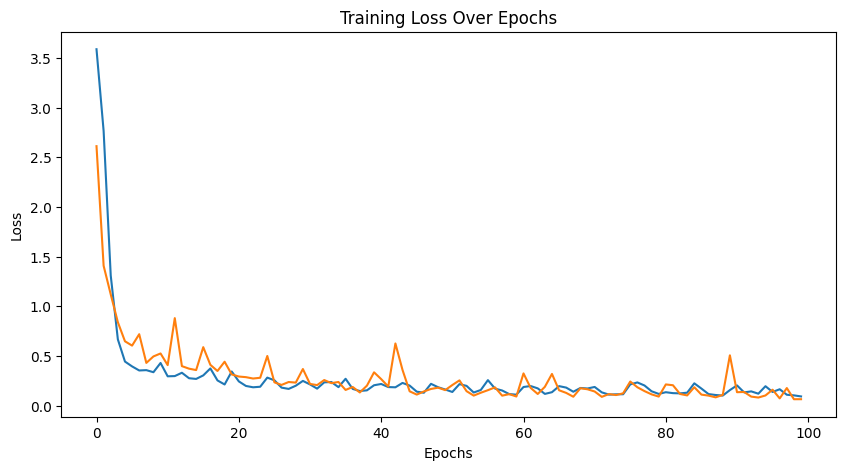

In [69]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

## Plot learning rate

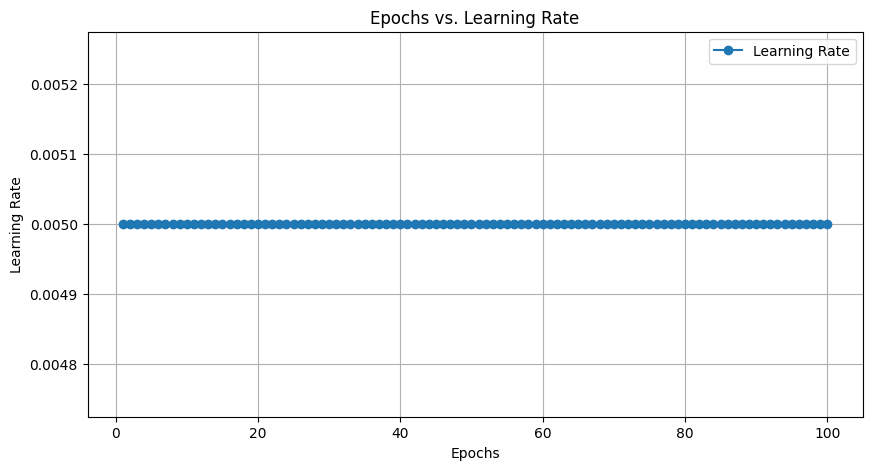

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), lr_history, marker='o', label="Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Epochs vs. Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

# Model Testing

## Selecting the best model for testing

In [71]:
# Directory path
directory = '/kaggle/working/best_models'

# Get the list of files in the directory
files = os.listdir(directory)

def extract_info(filename):
    parts = filename.split('_')
    epoch_value = int(parts[parts.index('epoch') + 1])
    accuracy_value = float(parts[parts.index('accuracy') + 1])
    loss_value = float(parts[parts.index('loss') + 1].replace('.pt', ''))
    return epoch_value, accuracy_value, loss_value


# Function to find the best model using both loss and accuracy
def find_best_model_using_normalization(file_list, weight_loss=0.5, weight_accuracy=0.5):
    best_model = None
    best_combined_metric = float('-inf')
    combined_matrix_values = []
    saved_models = []

    # Extract accuracy and loss from the filenames
    for f in file_list:
        file_info =  extract_info(f)
        saved_models.append({'filename': f,'epoch' : file_info[0], 'accuracy': file_info[1], 'loss': file_info[2]})

    # Calculate statistical parameters needed for normalization
    losses = [model['loss'] for model in saved_models]
    accuracies = [model['accuracy'] for model in saved_models]

    max_loss = 100
    min_loss = 0
    max_accuracy = 100
    min_accuracy = 0

    # Apply the selected normalization method
    for model_info in saved_models:
        loss = model_info['loss']
        accuracy = model_info['accuracy']
        normalized_loss = (loss - min_loss) / (max_loss - min_loss)
        normalized_accuracy = (accuracy - min_accuracy)/(max_accuracy - min_accuracy)
        
        # Combined metric: prioritize higher accuracy and lower loss
        combined_metric = (weight_accuracy * normalized_accuracy) - (weight_loss * normalized_loss)
        combined_matrix_values.append(combined_metric)

        # Find the model with the highest combined metric
        if combined_metric > best_combined_metric:
            best_combined_metric = combined_metric
            best_model = model_info

    # Print best model information
    if best_model:
        print_log(f"Best model - File: {best_model['filename']}, Accuracy: {best_model['accuracy']:.6f}, Loss: {best_model['loss']:.6f}")
        print_log(f"Best combined metric: {best_combined_metric} in all combined metrics: {combined_matrix_values}")

    return best_model

# Find the best model using Min-Max Normalization
print_log("Best Model using Min-Max Normalization")
best_model = find_best_model_using_normalization(files)



best_model_file = best_model['filename']
best_acc = best_model['accuracy']
best_loss = best_model['loss']
wandb.log({
    "best_model_epoch": best_model["epoch"],
    "best_model_accuracy": best_model['accuracy'],
    "best_model_loss": best_model['loss']
})

# Load the best model
best_model_path = os.path.join(directory, best_model_file)
test_model = torch.load(best_model_path)

print_log(f"Best model: {best_model_file} with accuracy: {best_acc} and loss: {best_loss}")
print_log(f"Loaded model from: {best_model_path}")

INFO    | Line 60  | Best Model using Min-Max Normalization
INFO    | Line 54  | Best model - File: epoch_100_accuracy_0.985007_loss_0.091505.pt, Accuracy: 0.985007, Loss: 0.091505
INFO    | Line 55  | Best combined metric: 0.004467509999999999 in all combined metrics: [0.00431635, 0.00414782, 0.00441287, 0.004091625, 0.004467509999999999, 0.00435606, 0.004332875, 0.004044374999999999, 0.004381545000000001, 0.004330735]
INFO    | Line 78  | Best model: epoch_100_accuracy_0.985007_loss_0.091505.pt with accuracy: 0.985007 and loss: 0.091505
INFO    | Line 79  | Loaded model from: /kaggle/working/best_models/epoch_100_accuracy_0.985007_loss_0.091505.pt


/tmp/ipykernel_23/1795502554.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(best_model_path)


In [72]:
testing_data=testing_imu_data

In [73]:
test_model.eval()

MultiSensorModel(
  (sensor_model_1): Model(
    (imu_transformer): Transformer(
      (pos_encoding): PositionalEncoding()
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-4): 5 x TransformerEncoderLayer(
            (attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=36, out_features=36, bias=True)
            )
            (_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (attn_norm): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
            (cnn): Sequential(
              (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Dropout(p=0.1, inplace=False)
              (3): ReLU()
              (4): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

In [74]:
test_model.train(False)

MultiSensorModel(
  (sensor_model_1): Model(
    (imu_transformer): Transformer(
      (pos_encoding): PositionalEncoding()
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-4): 5 x TransformerEncoderLayer(
            (attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=36, out_features=36, bias=True)
            )
            (_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (attn_norm): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
            (cnn): Sequential(
              (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Dropout(p=0.1, inplace=False)
              (3): ReLU()
              (4): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

## Testing

In [75]:
testing_data=testing_imu_data
test_dataset = TestDataset(testing_data)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [76]:
if hasattr(test_model, 'cross_attention_layer'):
    print_log("Cross attention layer is present.")
else:
    print_log("Cross attention layer is missing.")

INFO    | Line 2   | Cross attention layer is present.


In [77]:
# Get a list of files in the BEST_MODEL_PATH directory
BEST_MODEL_PATH='/kaggle/working/best_models/'
existing_models = os.listdir(BEST_MODEL_PATH)
best_accuracy_test=0
best_precision_test=0
best_recall_test=0
best_f1_test=0

# Loop through the files in the directory
for model_file in existing_models:
    feature_embeddings = []
    all_preds_test = []
    all_labels_test = []
    # Full path of the model
    model_path = os.path.join(BEST_MODEL_PATH, model_file)

    # Check if it's a file (and not a directory)
    if os.path.isfile(model_path):
        print(f"Processing model: {model_file}")
        test_model = torch.load(model_path)
        test_model.eval()
        test_model.train(False)
        for batch_idx_t, item_t in enumerate(test_dataloader):
            with torch.no_grad():
        
                item_t_in,class_label=item_t
        
                true_labels=class_label
        
                item_out = test_model(item_t_in.float()[:, :, :feature_length],
                        item_t_in.float()[:, :, feature_length:feature_length*2],
                        item_t_in.float()[:,:,feature_length*2:feature_length*3],
                        item_t_in.float()[:,:,feature_length*3:feature_length*4],
                        item_t_in.float()[:,:,feature_length*4:feature_length*5],
                        item_t_in.float()[:,:,feature_length*5:feature_length*6],
                        item_t_in.float()[:,:,feature_length*6:])
                class_scores=item_out[0]
                feature_embeddings.append(item_out[1])
                predicted_classes = torch.argmax(class_scores, dim=1)
                all_preds_test.extend(predicted_classes.tolist())
                all_labels_test.extend(true_labels.tolist())
        accuracy_test = accuracy_score(all_labels_test, all_preds_test)
        precision_test = precision_score(all_labels_test, all_preds_test, average='macro')
        recall_test = recall_score(all_labels_test, all_preds_test, average='macro')
        f1_test = f1_score(all_labels_test, all_preds_test, average='macro')
        
        
        print_log(f"Accuracy: {accuracy_test:.6f} - Precision: {precision_test:.6f} - Recall: {recall_test:.6f} - F1: {f1_test:.6f}")
        if accuracy_test>best_accuracy_test:
            final_best_model=model_path
        best_accuracy_test = max(best_accuracy_test, accuracy_test)
        best_precision_test =max(best_precision_test,precision_test)
        best_recall_test =max(best_recall_test,recall_test)
        best_f1_test=max(best_f1_test,f1_test)
        
wandb.log({"Test Accuracy": best_accuracy_test, "Test Precision": best_precision_test, "Test Recall": best_recall_test, 'Test f1':best_f1_test})
print_log(final_best_model)

Processing model: epoch_94_accuracy_0.982329_loss_0.119059.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.935511 - Precision: 0.532713 - Recall: 0.511793 - F1: 0.498570
Processing model: epoch_58_accuracy_0.980723_loss_0.151159.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.933617 - Precision: 0.598063 - Recall: 0.516951 - F1: 0.524797
Processing model: epoch_99_accuracy_0.984739_loss_0.102165.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.942965 - Precision: 0.593577 - Recall: 0.553162 - F1: 0.552600
Processing model: epoch_97_accuracy_0.982062_loss_0.163737.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.935747 - Precision: 0.578793 - Recall: 0.529638 - F1: 0.520760
Processing model: epoch_100_accuracy_0.985007_loss_0.091505.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.941900 - Precision: 0.599615 - Recall: 0.541432 - F1: 0.546355
Processing model: epoch_60_accuracy_0.980455_loss_0.109243.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.933736 - Precision: 0.605903 - Recall: 0.506297 - F1: 0.502801
Processing model: epoch_80_accuracy_0.983400_loss_0.116825.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.939652 - Precision: 0.644702 - Recall: 0.547213 - F1: 0.554391
Processing model: epoch_63_accuracy_0.981526_loss_0.172651.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.939770 - Precision: 0.614083 - Recall: 0.554623 - F1: 0.556784
Processing model: epoch_88_accuracy_0.982062_loss_0.105753.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.937522 - Precision: 0.631883 - Recall: 0.557919 - F1: 0.540193
Processing model: epoch_87_accuracy_0.981258_loss_0.115111.pt


/tmp/ipykernel_23/612440354.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(model_path)


INFO    | Line 48  | Accuracy: 0.931842 - Precision: 0.646123 - Recall: 0.525913 - F1: 0.526794
INFO    | Line 57  | /kaggle/working/best_models/epoch_99_accuracy_0.984739_loss_0.102165.pt


In [78]:
len(testing_imu_data[0])


3

In [79]:
feature_embeddings = []
all_preds_test = []
all_labels_test = []
test_model = torch.load(final_best_model)
test_model.eval()
test_model.train(False)

/tmp/ipykernel_23/4133426686.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(final_best_model)


MultiSensorModel(
  (sensor_model_1): Model(
    (imu_transformer): Transformer(
      (pos_encoding): PositionalEncoding()
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-4): 5 x TransformerEncoderLayer(
            (attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=36, out_features=36, bias=True)
            )
            (_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (attn_norm): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
            (cnn): Sequential(
              (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Dropout(p=0.1, inplace=False)
              (3): ReLU()
              (4): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

In [80]:

for batch_idx_t, item_t in enumerate(test_dataloader):
    with torch.no_grad():

        item_t_in,class_label=item_t

        true_labels=class_label

        item_out = test_model(item_t_in.float()[:, :, :feature_length],
                        item_t_in.float()[:, :, feature_length:feature_length*2],
                        item_t_in.float()[:,:,feature_length*2:feature_length*3],
                        item_t_in.float()[:,:,feature_length*3:feature_length*4],
                        item_t_in.float()[:,:,feature_length*4:feature_length*5],
                        item_t_in.float()[:,:,feature_length*5:feature_length*6],
                        item_t_in.float()[:,:,feature_length*6:])
        
        
        class_scores=item_out[0]
        feature_embeddings.append(item_out[1])
        predicted_classes = torch.argmax(class_scores, dim=1)
        all_preds_test.extend(predicted_classes.tolist())
        all_labels_test.extend(true_labels.tolist())

In [81]:
accuracy_test = accuracy_score(all_labels_test, all_preds_test)
precision_test = precision_score(all_labels_test, all_preds_test, average='macro')
recall_test = recall_score(all_labels_test, all_preds_test, average='macro')
f1_test = f1_score(all_labels_test, all_preds_test, average='macro')
precision_test_weighted = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test_weighted = recall_score(all_labels_test, all_preds_test, average='weighted')
f1_test_weighted = f1_score(all_labels_test, all_preds_test, average='weighted')

print_log(f"Accuracy: {accuracy_test:.6f} - Precision: {precision_test:.6f} - Recall: {recall_test:.6f} - F1: {f1_test:.6f}")

print_log(f"Accuracy: {accuracy_test:.6f} - precision_test_weighted: {precision_test_weighted:.6f} - recall_test_weighted: {recall_test_weighted:.6f} - f1_test_weighted: {f1_test_weighted:.6f}")
wandb.log({"Test Accuracy": accuracy_test, "Test Precision": precision_test, "Test Recall": recall_test, 'Test f1':f1_test})

INFO    | Line 9   | Accuracy: 0.942965 - Precision: 0.593577 - Recall: 0.553162 - F1: 0.552600
INFO    | Line 11  | Accuracy: 0.942965 - precision_test_weighted: 0.935197 - recall_test_weighted: 0.942965 - f1_test_weighted: 0.936224


# Results

## Confusion Matrix for test

INFO    | Line 8   | Accuracy for class 0: 0.994588
INFO    | Line 8   | Accuracy for class 1: 0.727273
INFO    | Line 8   | Accuracy for class 2: 0.609195
INFO    | Line 8   | Accuracy for class 3: 0.857143
INFO    | Line 8   | Accuracy for class 4: 1.000000
INFO    | Line 8   | Accuracy for class 5: 0.884615
INFO    | Line 8   | Accuracy for class 6: 0.984000
INFO    | Line 8   | Accuracy for class 7: 0.550000
INFO    | Line 8   | Accuracy for class 8: 0.603448
INFO    | Line 8   | Accuracy for class 9: 0.176471
INFO    | Line 8   | Accuracy for class 10: 0.189189
INFO    | Line 8   | Accuracy for class 11: 0.000000
INFO    | Line 8   | Accuracy for class 12: 0.240000
INFO    | Line 8   | Accuracy for class 13: 0.293103
INFO    | Line 8   | Accuracy for class 14: 0.019231
INFO    | Line 8   | Accuracy for class 15: 0.652174
INFO    | Line 8   | Accuracy for class 16: 0.914956
INFO    | Line 8   | Accuracy for class 17: 0.261538


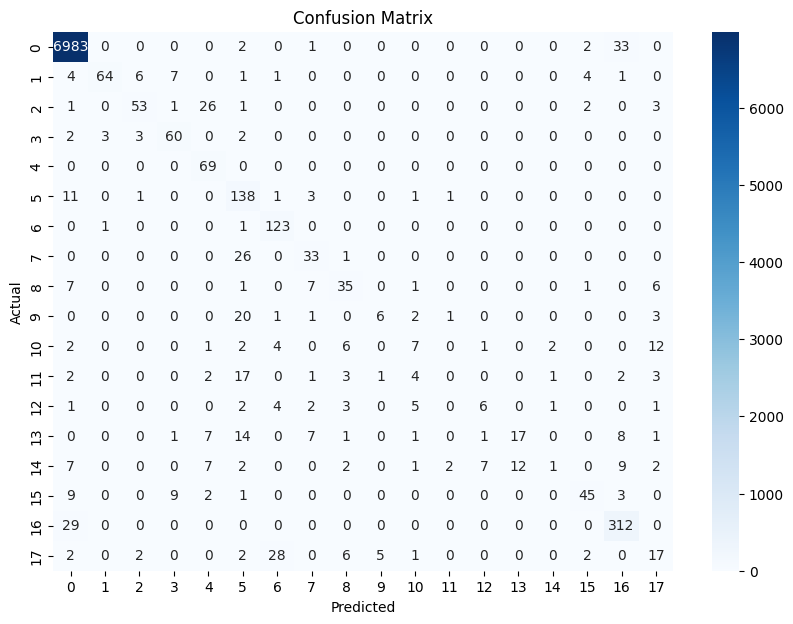

INFO    | Line 19  | Confusion matrix is create sucessfully using test


In [82]:
conf_matrix = confusion_matrix(all_labels_test, all_preds_test)

# Calculate the accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print the accuracy for each class
for i, class_accuracy in enumerate(class_accuracies):
    print_log(f"Accuracy for class {i}: {class_accuracy:.6f}")


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
image_path = 'confusion_matrix.png'
plt.savefig(image_path)
plt.show()
print_log("Confusion matrix is create sucessfully using test")
wandb.log({"confusion_matrix_test": wandb.Image('confusion_matrix.png')})

## Confusion Matrix for test using percentage

INFO    | Line 12  | Accuracy for class 0: 99.5%
INFO    | Line 12  | Accuracy for class 1: 72.7%
INFO    | Line 12  | Accuracy for class 2: 60.9%
INFO    | Line 12  | Accuracy for class 3: 85.7%
INFO    | Line 12  | Accuracy for class 4: 100.0%
INFO    | Line 12  | Accuracy for class 5: 88.5%
INFO    | Line 12  | Accuracy for class 6: 98.4%
INFO    | Line 12  | Accuracy for class 7: 55.0%
INFO    | Line 12  | Accuracy for class 8: 60.3%
INFO    | Line 12  | Accuracy for class 9: 17.6%
INFO    | Line 12  | Accuracy for class 10: 18.9%
INFO    | Line 12  | Accuracy for class 11: 0.0%
INFO    | Line 12  | Accuracy for class 12: 24.0%
INFO    | Line 12  | Accuracy for class 13: 29.3%
INFO    | Line 12  | Accuracy for class 14: 1.9%
INFO    | Line 12  | Accuracy for class 15: 65.2%
INFO    | Line 12  | Accuracy for class 16: 91.5%
INFO    | Line 12  | Accuracy for class 17: 26.2%


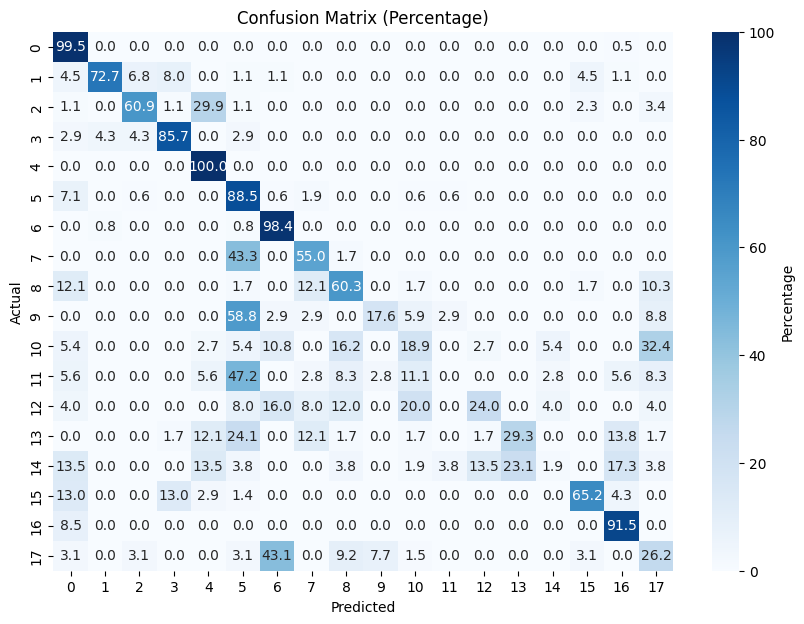

INFO    | Line 24  | Confusion matrix is created successfully using test data in percentage.


In [83]:

# Assuming 'all_labels_test' and 'all_preds_test' are your ground truth and predictions
conf_matrix = confusion_matrix(all_labels_test, all_preds_test)

# Normalize the confusion matrix to get percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Calculate the accuracy for each class (as percentages)
class_accuracies = conf_matrix_percentage.diagonal()

# Print the accuracy for each class in percentage (rounded to 1 decimal)
for i, class_accuracy in enumerate(class_accuracies):
    print_log(f"Accuracy for class {i}: {class_accuracy:.1f}%")

# Plot confusion matrix in percentage
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
image_path = 'confusion_matrix_percentage.png'
plt.savefig(image_path)

plt.show()
print_log("Confusion matrix is created successfully using test data in percentage.")
wandb.log({"confusion_matrix_percentage_test": wandb.Image(image_path)})

In [84]:

# Move each tensor to CPU, detach from computation graph, and convert to NumPy array
feature_embeddings_cpu = [emb.cpu().detach().numpy() for emb in feature_embeddings]

# Check for NaNs in individual arrays
for i, emb_np in enumerate(feature_embeddings_cpu):
    if np.isnan(emb_np).any():
        print_log(f"NaN detected in feature_embeddings_cpu at index {i}")

# Concatenate the list of numpy arrays into a single numpy array
feature_embeddings_np = np.concatenate(feature_embeddings_cpu, axis=0)



In [85]:
# Map activities to IDs with sequential keys from 0 to len(all_list)-1
activity_id_mapping = {idx: activity for idx, activity in enumerate(activity_names)}

# Output the results
# print("Shuffled Activity Names:", activity_names)
print("Activity ID Mapping:", activity_id_mapping)

Activity ID Mapping: {0: 'ADL0', 1: 'ADL1', 2: 'ADL2', 3: 'ADL3', 4: 'ADL4', 5: 'ADL5', 6: 'ADL6', 7: 'ADL7', 8: 'ADL8', 9: 'ADL9', 10: 'ADL10', 11: 'ADL11', 12: 'ADL12', 13: 'ADL13', 14: 'ADL14', 15: 'ADL15', 16: 'ADL16', 17: 'ADL17'}


## Calculate matrix for each classes

In [86]:
# Calculate metrics for each class
results_df = pd.DataFrame(columns=columns)
accuracy_list = []
class_names = []
precision_list = []
recall_list = []
f1_list = []
for class_id, class_name in activity_id_mapping.items():
    # Get the true positive (diagonal) for the class and sum of the row (total samples for that class)
    true_positive = conf_matrix[class_id, class_id]
    total_samples = conf_matrix[class_id].sum()

    # Accuracy per class (True positives / Total samples in class)
    accuracy = true_positive / total_samples if total_samples > 0 else 0
    
    # Calculate precision, recall, and F1 score for the current class
    precision = precision_score(all_labels_test, all_preds_test, labels=[class_id], average='weighted', zero_division=0)
    recall = recall_score(all_labels_test, all_preds_test, labels=[class_id], average='weighted', zero_division=0)
    f1 = f1_score(all_labels_test, all_preds_test, labels=[class_id], average='weighted', zero_division=0)

    # Append results to respective lists
    class_names.append(class_name)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Calculate the average across all classes (macro average)
average_accuracy = sum(accuracy_list) / len(accuracy_list)
average_precision = sum(precision_list) / len(precision_list)
average_recall = sum(recall_list) / len(recall_list)
average_f1 = sum(f1_list) / len(f1_list)

# Append the average values to the lists
class_names.append('Average')
accuracy_list.append(average_accuracy)
precision_list.append(average_precision)
recall_list.append(average_recall)
f1_list.append(average_f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-score': f1_list
})

# Save the results to CSV
results_df.to_csv('class_precision_recall_f1.csv', index=False)

# Display the final table
results_df

,Class,Accuracy,Precision,Recall,F1-score
0,ADL0,0.994588,0.989093,0.994588,0.991833
1,ADL1,0.727273,0.941176,0.727273,0.820513
2,ADL2,0.609195,0.815385,0.609195,0.697368
3,ADL3,0.857143,0.769231,0.857143,0.810811
4,ADL4,1.000000,0.605263,1.000000,0.754098
5,ADL5,0.884615,0.594828,0.884615,0.711340
6,ADL6,0.984000,0.759259,0.984000,0.857143
7,ADL7,0.550000,0.600000,0.550000,0.573913
8,ADL8,0.603448,0.614035,0.603448,0.608696
9,ADL9,0.176471,0.500000,0.176471,0.260870


## t-SNE Visualization

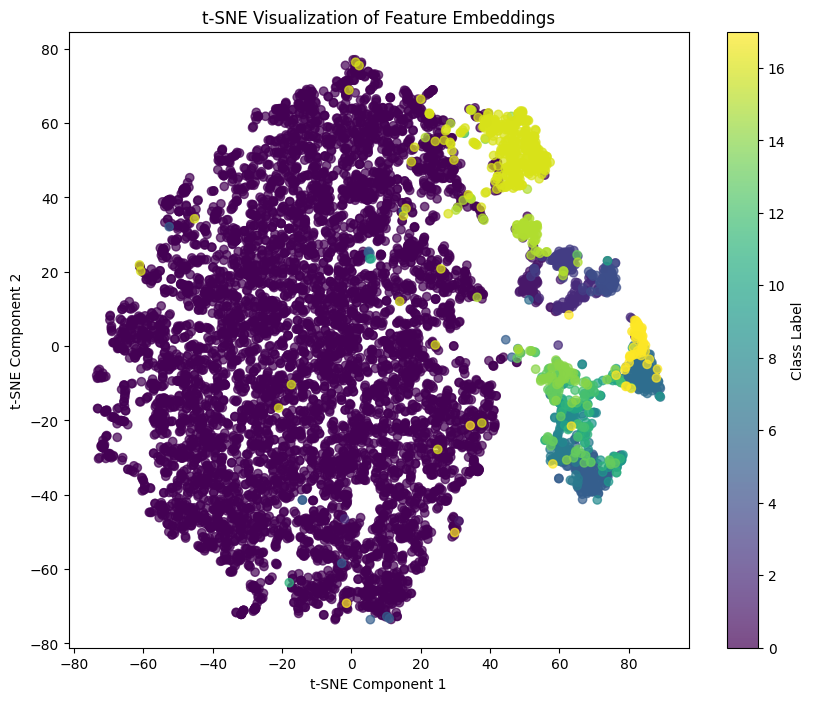

In [87]:


# Example feature embeddings and corresponding labels
# Replace these with your actual feature embeddings and labels
embeddings = feature_embeddings_np  # 100 samples, 128-dimensional embeddings
labels =np.stack(all_labels_test, axis=0) # 100 samples, 10 different classes

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Visualization of Feature Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
image_path = 'tsne_plot.png'
plt.savefig(image_path)

# Log the image to wandb
wandb.log({
    "tsne_plot": wandb.Image(image_path)  # Log the t-SNE plot image
})
plt.show()



In [88]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:       Test Accuracy ▁▁
wandb:      Test Precision █▁
wandb:         Test Recall █▁
wandb:             Test f1 █▁
wandb:            accuracy ▁▃▆▇▇█▇███▇█████████████████████████████
wandb: best_model_accuracy ▁
wandb:    best_model_epoch ▁
wandb:     best_model_loss ▁
wandb:                  f1 ▁▃▅▅▅▆▆▅▇▇▇▅▇▇▇▇▇▆█▇▇▇▆█▇█▆█▇█▇▇███▇█▇██
wandb:                loss █▅▅▄▅▃▃▃▄▃▃▂▂▂▂▃▂▂▂▂▂▁▂▁▁▂▂▁▁▁▂▁▃▁▁▂▁▂▁▁
wandb:                  lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           precision ▁▃▆▇▆▇▇▇▇▇▇▇▇▇██▇█████████████████▇█████
wandb:              recall ▁▃▄▄▅▆▆▅▆▆▆▆▅▆▇▇▇▇▅▆█▇█▇█▇▇▇█▇█▇█▇▇▆█▇▇█
wandb:              v_loss █▇▄▅█▄▄▄▃▃▂▂▂▄▂▃▂▂▂▂▆▂▂▂▁▃▁▃▂▁▂▁▂▃▂▂▁▁▁▁
wandb: 
wandb: Run summary:
wandb:       Test Accuracy 0.94297
wandb:      Test Precision 0.59358
wandb:         Test Recall 0.55316
wandb:             Test f1 0.5526
wandb:            accuracy 0.98501
